# STEP 0 : **Setup**

In [ ]:
# Cell 0.1: Setup - Import libraries and define database connection
# This cell imports necessary Python libraries for data handling (pandas),
import pandas as pd
import requests, gzip, json, io, csv, psycopg2, re

# This variable holds the connection details for the PostgreSQL database.

PG_CONN_STR = "host=natedemorodatabase1.cdwks2ccsvza.us-east-2.rds.amazonaws.com dbname=NateDeMoroDatabase1 user=NateDeMoro password=NaNi8899! sslmode=require"

def get_conn():
    # Small helper function to establish a new database connection.
    return psycopg2.connect(PG_CONN_STR)

In [ ]:
# Cell 0.2: Bootstrap - Schema Creation, Search Path, and Helper Function
# This cell performs initial setup for the database schema and creates a utility function.

NEW_SCHEMA = "vgprojForProfessor"

# Establish a database connection using the helper function
with get_conn() as conn, conn.cursor() as cur:
    # This ensures a clean workspace without affecting other schemas.
    cur.execute(f"CREATE SCHEMA IF NOT EXISTS {NEW_SCHEMA};")

    # 2) Set the search_path for the current session.
    cur.execute(f"SET search_path TO {NEW_SCHEMA}, public;")
    conn.commit() # Commit the schema creation and search_path setting

print(f"✅ Schema '{NEW_SCHEMA}' ready and search_path set.")

# 3) Create or replace the normalize_title() function in this schema.
# This SQL function is crucial for data cleaning. It standardizes game and product titles
# by:
#    - Converting text to lowercase.
#    - Removing trademark/copyright symbols (®, ™, ©).
#    - Replacing characters that are not letters, numbers, space, colon, hyphen, or ampersand with spaces.
#    - Collapsing multiple spaces into a single space.
# This normalization is essential for reliable joining of game data from different sources
# (VGChartz and Amazon) where titles might have slight variations.
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
    CREATE OR REPLACE FUNCTION normalize_title(txt TEXT)
    RETURNS TEXT LANGUAGE SQL IMMUTABLE AS $$
      SELECT regexp_replace(
               regexp_replace(
                 regexp_replace(lower(coalesce($1,'')), '[®™©]', '', 'g'),
                 '[^a-z0-9\\s:\\-&'']', ' ', 'g'
               ),
               '\\s+', ' ', 'g'
             )::text
    $$;
    """)
    conn.commit() # Commit the function creation

print("✅ normalize_title() function created in schema:", NEW_SCHEMA)

# 4) Verify that the schema is currently empty.
# This check confirms that we are starting with a clean schema, as expected for a fresh ETL run.
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
      SELECT COUNT(*)
      FROM information_schema.tables
      WHERE table_schema = %s;
    """, (NEW_SCHEMA,))
    n = cur.fetchone()[0]

print(f"ℹ️ Schema '{NEW_SCHEMA}' currently has {n} tables (should be 0 for a fresh start).")

✅ Schema 'vgproj' ready and search_path set.
✅ normalize_title() function created in schema: vgproj
ℹ️ Schema 'vgproj' currently has 0 tables (should be 0 for a fresh start).


# **STEP 1 : Extract(Raw -> Staging)**

In [ ]:
# Cell 1.1: Load Raw Data into Pandas DataFrames
# This cell loads the raw data from public S3 URLs into pandas DataFrames for initial inspection


# Public S3 CSV URLs
SALES_URL   = "https://natedemorofinalprojectbucket.s3.us-east-2.amazonaws.com/vgsales.csv"
REVIEWS_URL = "https://natedemorofinalprojectbucket.s3.us-east-2.amazonaws.com/data.csv"

# Read into pandas
df_sales   = pd.read_csv(SALES_URL)
df_reviews = pd.read_csv(REVIEWS_URL)

# Peek at the first few rows to confirm expected columns
display(df_sales.head(3))
display(df_reviews.head(3))

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,0.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,3.0,Good rally game,1372550400,"06 30, 2013"
2,2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,0.0,Wrong key,1403913600,"06 28, 2014"


In [ ]:
# Cell 1.2: Create STAGING tables
# This cell defines and creates the initial staging tables in the database.
# These tables are designed to hold the raw data directly from the source files
# with minimal transformation, primarily casting everything to TEXT initially
# to avoid data type errors during the initial load and to preserve the raw format
# for later inspection and cleaning.

ddl_staging = """
-- Raw VGChartz sales (keep everything TEXT here; cast in transforms later)
-- This table stores the raw sales data from the VGChartz CSV.
-- Columns are named descriptively to indicate their raw source.
CREATE TABLE IF NOT EXISTS stg_sales_vgchartz (
    rank_text           TEXT,        -- Rank from the source file
    name_raw            TEXT,        -- Original game name
    platform_raw        TEXT,    -- Original platform string
    year_raw            TEXT,        -- Original year string
    genre_raw           TEXT,        -- Original genre string
    publisher_raw       TEXT,    -- Original publisher string
    na_sales_raw        TEXT,    -- Original North America sales string (in millions)
    eu_sales_raw        TEXT,    -- Original Europe sales string (in millions)
    jp_sales_raw        TEXT,    -- Original Japan sales string (in millions)
    other_sales_raw     TEXT,    -- Original Other regions sales string (in millions)
    global_sales_raw    TEXT         -- Original Global sales string (in millions)
);

-- Raw Amazon reviews (Hugging Face CSV)
-- This table stores raw review data from the Amazon review CSV.
-- ASIN (Amazon Standard Identification Number) is used as the primary key from the source.
CREATE TABLE IF NOT EXISTS stg_reviews_amazon (
    reviewerid          TEXT,        -- Unique identifier for the reviewer
    asin                TEXT,        -- ASIN from the source (used for linking to products)
    reviewername        TEXT,    -- Name of the reviewer
    helpful_raw         TEXT,        -- Raw string indicating helpfulness count (e.g., "[2, 5]")
    reviewtext          TEXT,    -- Full text of the review
    overall_raw         TEXT,    -- Raw string of the overall rating (1-5)
    summary             TEXT,        -- Short summary or title of the review
    unixreviewtime_raw  TEXT,    -- Raw Unix timestamp for the review date
    reviewtime_raw      TEXT         -- Raw textual date string for the review
);

-- Raw Amazon product metadata (UCSD JSONL)
-- This table stores raw metadata for Amazon products, particularly video games.
-- It includes ASIN, title, categories, price, and the full raw JSON object.
-- Storing the raw JSON allows for flexible parsing and extraction of fields later.
CREATE TABLE IF NOT EXISTS stg_amazon_meta (
    asin        TEXT,        -- ASIN from the source (links to reviews)
    title_raw   TEXT,    -- Original product title
    categories  JSONB,       -- Product categories stored as JSONB for flexible querying
    price       NUMERIC,     -- Product price (nullable)
    raw         JSONB        -- The complete raw JSON object for the product
);
"""
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(ddl_staging)
    conn.commit()
print("Created/verified: stg_sales_vgchartz, stg_reviews_amazon, stg_amazon_meta")

Created/verified: stg_sales_vgchartz, stg_reviews_amazon, stg_amazon_meta


# **STEP 2 : Quick Profiling**

In [ ]:
# Cell 2.1: Load Sales dataframe into stg_sales_vgchartz
# This cell loads the raw sales data, previously read into a pandas DataFrame (df_sales),
# into the stg_sales_vgchartz staging table in the database.

import pandas as pd
import io

# Define a mapping from desired database column names to the original DataFrame column names.
# This ensures the data is loaded into the correct columns in the staging table,
# maintaining the raw structure.
sales_map = {
    "rank_text":        "Rank",
    "name_raw":         "Name",
    "platform_raw":     "Platform",
    "year_raw":         "Year",
    "genre_raw":        "Genre",
    "publisher_raw":    "Publisher",
    "na_sales_raw":     "NA_Sales",
    "eu_sales_raw":     "EU_Sales",
    "jp_sales_raw":     "JP_Sales",
    "other_sales_raw":  "Other_Sales",
    "global_sales_raw": "Global_Sales"
}

# Reorder & rename columns exactly as staging expects
# This step ensures the DataFrame columns are in the exact order and named
# according to the stg_sales_vgchartz table definition, preparing it for the COPY command.
expected_sales_cols = list(sales_map.keys())
sales_rows = pd.DataFrame({k: df_sales.get(v) for k, v in sales_map.items()})[expected_sales_cols]

# COPY from an in-memory CSV buffer
# Using an in-memory buffer combined with PostgreSQL's COPY command is a very
# efficient way to load large amounts of data compared to row-by-row inserts.
buffer = io.StringIO()
sales_rows.to_csv(buffer, index=False, header=False)  # no header for COPY
buffer.seek(0) # Rewind the buffer to the beginning

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.copy_expert("""
            COPY stg_sales_vgchartz (
                rank_text, name_raw, platform_raw, year_raw, genre_raw, publisher_raw,
                na_sales_raw, eu_sales_raw, jp_sales_raw, other_sales_raw, global_sales_raw
            )
            FROM STDIN WITH (FORMAT csv)
        """, buffer)
    conn.commit()

print(f"Loaded {len(sales_rows):,} rows into stg_sales_vgchartz.")

Loaded 16,598 rows into stg_sales_vgchartz.


In [ ]:
# Cell 2.2: Load Reviews dataframe into stg_reviews_amazon
# This cell loads the raw reviews data, previously read into a pandas DataFrame (df_reviews),
# into the stg_reviews_amazon staging table in the database.

import pandas as pd
import io

# Define a mapping from desired database column names to the original DataFrame column names.
# This ensures the data is loaded into the correct columns in the staging table,
# maintaining the raw structure.
reviews_map = {
    "reviewerid":         "reviewerID",
    "asin":               "asin",
    "reviewername":       "reviewerName",
    "helpful_raw":        "helpful",
    "reviewtext":         "reviewText",
    "overall_raw":        "overall",
    "summary":            "summary",
    "unixreviewtime_raw": "unixReviewTime",
    "reviewtime_raw":     "reviewTime"
}

# Reorder & rename columns exactly as staging expects
# This step ensures the DataFrame columns are in the exact order and named
# according to the stg_reviews_amazon table definition, preparing it for the COPY command.
expected_reviews_cols = list(reviews_map.keys())
reviews_rows = pd.DataFrame({k: df_reviews.get(v) for k, v in reviews_map.items()})[expected_reviews_cols]

# COPY from an in-memory CSV buffer
# Using an in-memory buffer combined with PostgreSQL's COPY command is a very
# efficient way to load large amounts of data compared to row-by-row inserts.
buffer = io.StringIO()
reviews_rows.to_csv(buffer, index=False, header=False)  # no header for COPY
buffer.seek(0) # Rewind the buffer to the beginning

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.copy_expert("""
            COPY stg_reviews_amazon (
                reviewerid, asin, reviewername, helpful_raw, reviewtext,
                overall_raw, summary, unixreviewtime_raw, reviewtime_raw
            )
            FROM STDIN WITH (FORMAT csv)
        """, buffer)
    conn.commit()

print(f"Loaded {len(reviews_rows):,} rows into stg_reviews_amazon.")

Loaded 50,000 rows into stg_reviews_amazon.


In [ ]:
# Cell 2.3: Download Amazon Product Metadata
# This cell downloads the compressed Amazon product metadata file (JSON Lines, gzipped)
# from a public S3 URL to a local path within the Colab environment.
# This is necessary because the metadata file is too large to process directly
# from the web and needs to be accessed from the local file system.

# Public S3 URL to Amazon metadata
META_URL   = "https://natedemorofinalprojectbucket.s3.us-east-2.amazonaws.com/meta_Video_Games.jsonl.gz"
LOCAL_META = "/content/meta_Video_Games.jsonl.gz"

# Stream-download to local path
with requests.get(META_URL, stream=True) as r:
    r.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(LOCAL_META, "wb") as f: # Open the local file in write-binary mode
        for chunk in r.iter_content(chunk_size=1024*1024):  # Iterate over the response in 1MB chunks
            f.write(chunk) # Write each chunk to the local file

print("Downloaded metadata to:", LOCAL_META)

Downloaded metadata to: /content/meta_Video_Games.jsonl.gz


In [ ]:
# Cell 2.4: Cancel all blockers on a table (default: stg_amazon_meta)
# This cell helps resolve database locking issues by identifying and canceling
# sessions that are blocking operations on a specific table.


TABLE_NAME = "stg_amazon_meta"
ESCALATE_TERMINATE = False


from time import sleep

with get_conn() as conn, conn.cursor() as cur:
    # 1) List blockers
    # This query identifies sessions that are holding locks on the specified table
    # and preventing other sessions from acquiring necessary locks (bl.granted = false).
    cur.execute(f"""
    WITH locks AS (
      SELECT bl.pid AS blocked_pid, -- The PID of the session being blocked
             ka.pid AS blocking_pid, -- The PID of the session holding the lock
             now()-ka.query_start AS blocking_for, -- How long the blocking query has been running
             kl.relation::regclass AS table_name, -- The table involved
             ka.state AS blocking_state, -- State of the blocking session (e.g., active, idle in transaction)
             left(ka.query, 200) AS blocking_query -- The query being executed by the blocking session
      FROM pg_locks bl
      JOIN pg_locks kl ON bl.locktype = kl.locktype
                      AND bl.relation = kl.relation
                      AND bl.pid <> kl.pid
      JOIN pg_stat_activity ka ON ka.pid = kl.pid
      WHERE bl.granted = false -- Only show locks that are blocking others
        AND kl.relation::regclass::text LIKE %s -- Filter by the specified table name
    )
    SELECT * FROM locks;
    """, (f"%{TABLE_NAME}%",))
    blockers = cur.fetchall()

if not blockers:
    print(f"✅ No blockers found on {TABLE_NAME}.")
else:
    print(f"Found {len(blockers)} blocker(s) on {TABLE_NAME}:")
    for b in blockers:
        print(" - blocked_pid:", b[0], "| blocking_pid:", b[1], "| for:", b[2], "| state:", b[4])
        print("   table:", b[3], "| query:", b[5])

    # 2) Try to cancel each blocker (gentle approach)
    # pg_cancel_backend() sends a signal to cancel the currently running query
    canceled = []
    with get_conn() as conn, conn.cursor() as cur:
        for b in blockers:
            pid = b[1]
            cur.execute("SELECT pg_cancel_backend(%s);", (pid,))
            res = cur.fetchone()
            canceled.append((pid, res[0]))
        conn.commit() # Commit the cancellation requests

    for pid, ok in canceled:
        print(f"🟡 Cancel sent to PID {pid} -> {'accepted' if ok else 'not accepted'}")

    # 3) Re-check after a brief wait
    # Give the database a moment to process the cancellation requests
    sleep(2)
    with get_conn() as conn, conn.cursor() as cur:
        cur.execute(f"""
        SELECT ka.pid
        FROM pg_locks bl
        JOIN pg_locks kl ON bl.locktype = kl.locktype
                        AND bl.relation = kl.relation
                        AND bl.pid <> kl.pid
        JOIN pg_stat_activity ka ON ka.pid = kl.pid
        WHERE bl.granted = false
          AND kl.relation::regclass::text LIKE %s;
        """, (f"%{TABLE_NAME}%",))
        still_blocking = [r[0] for r in cur.fetchall()]

    if not still_blocking:
        print("✅ All blockers cleared.")
    else:
        print("⚠️ Still blocking PIDs:", still_blocking)
        if ESCALATE_TERMINATE:
            print("Attempting to terminate stubborn blockers...")
            with get_conn() as conn, conn.cursor() as cur:
                for pid in still_blocking:
                    cur.execute("SELECT pg_terminate_backend(%s);", (pid,))
                    res = cur.fetchone()
                    print(f"🔴 Terminate sent to PID {pid} -> {'terminated' if res and res[0] else 'failed'}")
                conn.commit() # Commit termination requests
        else:
            print("Set ESCALATE_TERMINATE = True to force-terminate stubborn blockers (use with care).")

✅ No blockers found on stg_amazon_meta.


In [ ]:
# Cell 2.5 — Load Amazon metadata into stg_amazon_meta
# This cell loads the Amazon product metadata from a gzipped JSON Lines file into the
# stg_amazon_meta staging table. It's optimized for speed using bulk loading (COPY)
# and provides progress updates.
# - Uses asin OR parent_asin for the primary identifier.
# - Prints progress (rows, %, elapsed, rows/sec).
# - Uses UNLOGGED staging table for faster bulk load (less WAL).

import os, io, csv, re, json, gzip, time, requests

META_URL   = "https://natedemorofinalprojectbucket.s3.us-east-2.amazonaws.com/meta_Video_Games.jsonl.gz"
LOCAL_META = "/content/meta_Video_Games.json.gz"

if not os.path.exists(LOCAL_META):
    print("Local file not found, downloading:", LOCAL_META)
    # Stream-download to local path
    # Using stream=True and iterating through chunks is important for large files
    # as it avoids loading the entire file into memory at once.
    with requests.get(META_URL, stream=True) as r:
        r.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        with open(LOCAL_META, "wb") as f: # Open the local file in write-binary mode
            for chunk in r.iter_content(chunk_size=1024*1024):  # Iterate over the response in 1MB chunks
                f.write(chunk) # Write each chunk to the local file
    print("Downloaded metadata to:", LOCAL_META)
else:
    print("Found local file, skipping download:", LOCAL_META)

# 1) Staging table (UNLOGGED = faster bulk load)
# UNLOGGED tables are faster for bulk loading because they don't write
# Write-Ahead Log (WAL) entries for their changes. This makes them ideal
# for staging tables that are truncated and reloaded frequently.
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
    CREATE TABLE IF NOT EXISTS stg_amazon_meta (
      asin        TEXT,        -- Amazon Standard Identification Number (or parent)
      title_raw   TEXT,    -- Original product title
      categories  JSONB,       -- Product categories as JSONB
      price       NUMERIC,     -- Product price (parsed)
      raw         JSONB        -- Full raw JSON object (for inspection if needed)
    );
    """)
    # Set the table to UNLOGGED for performance during the bulk load.
    cur.execute("ALTER TABLE stg_amazon_meta SET UNLOGGED;")
    conn.commit()

# 2) Truncate + bulk load with progress prints
# Truncating the table removes all existing rows quickly, preparing it for a fresh load.
with get_conn() as conn, conn.cursor() as cur:
    print("Truncating stg_amazon_meta...")
    cur.execute("TRUNCATE stg_amazon_meta;")
    print("Truncated.")

    buffer = io.StringIO() # In-memory text buffer to build CSV chunks
    writer = csv.writer(buffer) # CSV writer to format rows

    FLUSH_EVERY    = 200_000    # Number of rows to buffer before a COPY call (fewer, larger calls are faster)
    PRINT_EVERY    = 50_000     # How often to print progress updates (in rows)
    rows = 0                    # Counter for processed rows
    last_print_rows = 0
    t0 = time.perf_counter()    # Start time for timing

    comp_size = os.path.getsize(LOCAL_META)  # Get compressed file size for % progress (approximate)
    # Decompress + stream-parse JSONL
    # Open the gzipped file in text mode ('rt') for reading lines.
    with gzip.open(LOCAL_META, "rt", encoding="utf-8") as f:
        gz = f.fileobj if hasattr(f, "fileobj") else None
        while True:
            line = f.readline() # Read one line (one JSON object) at a time
            if not line:
                break # End of file

            o = json.loads(line) # Parse the JSON line into a Python dictionary

            # Prefer 'asin'; fallback to 'parent_asin' if 'asin' is missing or empty.
            # This is a data cleaning choice to ensure we have an identifier for each product.
            asin_val = o.get("asin") or o.get("parent_asin")

            # Extract numeric price like "$19.99" -> 19.99 (may be None)
            # This uses a regular expression to find numeric patterns in the price string.
            price = None
            p = o.get("price")
            if p is not None:
                m = re.search(r"\d+(\.\d+)?", str(p))
                if m:
                    try:
                        price = float(m.group(0)) # Convert the found numeric string to a float
                    except:
                        price = None # Handle cases where conversion fails unexpectedly

            # Buffer a CSV row for COPY
            # Write the extracted and cleaned data into the in-memory CSV buffer.
            writer.writerow([
                asin_val,
                o.get("title"),
                json.dumps(o.get("categories")), # Store categories as JSON string
                price,
                json.dumps(o, ensure_ascii=False),
            ])

            rows += 1


            # Print progress updates based on the number of rows processed and elapsed time.
            if rows % PRINT_EVERY == 0:
                elapsed = time.perf_counter() - t0
                rps = (rows / elapsed) if elapsed > 0 else 0
                # percent based on compressed bytes read (approximate)
                # Use the compressed file position to estimate percentage completion.
                pct = 0.0
                try:
                    if gz is not None:
                        pos = gz.tell()
                        if comp_size > 0:
                            pct = min(99.0, (pos / comp_size) * 100.0) # Cap at 99% as it's an estimate
                except Exception:
                    pass # Ignore errors during progress estimation
                print(f"[{rows:,} rows] ~{pct:5.1f}% | {elapsed:6.1f}s | {rps:,.0f} rows/s")

            # COPY in big batches
            # When the buffer reaches the FLUSH_EVERY threshold, copy the buffered data to the database.
            if rows % FLUSH_EVERY == 0:
                buffer.seek(0) # Rewind the buffer to the beginning
                # Execute the COPY command to load data from the in-memory buffer (STDIN).
                cur.copy_expert("""
                    COPY stg_amazon_meta (asin, title_raw, categories, price, raw)
                    FROM STDIN WITH (FORMAT csv)
                """, buffer)
                buffer.seek(0); buffer.truncate(0) # Clear the buffer for the next batch
                # Print batch completion progress.
                elapsed = time.perf_counter() - t0
                rps = (rows / elapsed) if elapsed > 0 else 0
                print(f"✓ Flushed {rows:,} rows | {elapsed:6.1f}s total | {rps:,.0f} rows/s")

        # Final flush
        # After the loop finishes, copy any remaining data in the buffer.
        if buffer.tell() > 0:
            buffer.seek(0)
            cur.copy_expert("""
                COPY stg_amazon_meta (asin, title_raw, categories, price, raw)
                FROM STDIN WITH (FORMAT csv)
            """, buffer)

    conn.commit() # Commit the transaction to make the loaded data permanent

elapsed = time.perf_counter() - t0
rps = (rows / elapsed) if elapsed > 0 else 0
print(f"✅ Done loading stg_amazon_meta. Total rows: {rows:,} | {elapsed:,.1f}s | {rps:,.0f} rows/s")


Local file not found, downloading: /content/meta_Video_Games.json.gz
Downloaded metadata to: /content/meta_Video_Games.json.gz
Truncating stg_amazon_meta...
Truncated.
[50,000 rows] ~  0.0% |   13.6s | 3,679 rows/s
[100,000 rows] ~  0.0% |   26.9s | 3,719 rows/s
✅ Done loading stg_amazon_meta. Total rows: 137,269 | 53.2s | 2,582 rows/s


# **STEP 3 : Transform Sales -> sales_clean**

In [ ]:
# Cell 3.1 - Create helpers: normalize_title() function + platform_map table (PostgreSQL)

with get_conn() as conn:
    with conn.cursor() as cur:
        # Create a deterministic text normalizer to make joins reliable
        cur.execute("""
        CREATE OR REPLACE FUNCTION normalize_title(txt TEXT)
        RETURNS TEXT
        LANGUAGE SQL
        IMMUTABLE
        AS $$
          SELECT regexp_replace(
                   regexp_replace(
                     regexp_replace(lower(coalesce($1,'')), '[®™©]', '', 'g'),     -- drop trademark symbols
                     '[^a-z0-9\\s:\\-&'']', ' ', 'g'                               -- keep letters/numbers/basic punctuation
                   ),
                   '\\s+', ' ', 'g'                                                -- collapse whitespace
                 )::text
        $$;
        """)

        # Table to map raw platform strings to a canonical name
        cur.execute("""
        CREATE TABLE IF NOT EXISTS platform_map (
          raw   TEXT PRIMARY KEY,
          clean TEXT NOT NULL
        );
        """)

        # Seed common platform aliases (safe to re-run because of ON CONFLICT)
        cur.execute("""
        INSERT INTO platform_map (raw, clean) VALUES
          ('ps4','PlayStation 4'),
          ('playstation 4','PlayStation 4'),
          ('ps5','PlayStation 5'),
          ('x360','Xbox 360'),
          ('xbox 360','Xbox 360'),
          ('xone','Xbox One'),
          ('xbox one','Xbox One'),
          ('wiiu','Wii U'),
          ('wii u','Wii U'),
          ('switch','Nintendo Switch'),
          ('ns','Nintendo Switch'),
          ('pc','PC')
        ON CONFLICT (raw) DO UPDATE SET clean = EXCLUDED.clean;
        """)
    conn.commit()

print("Helpers ready: normalize_title() + platform_map")


Helpers ready: normalize_title() + platform_map


In [ ]:
# Cell 3.2 - Build a normalized sales view from staging (sales_norm_v)

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
        DROP VIEW IF EXISTS sales_norm_v;
        CREATE VIEW sales_norm_v AS
        SELECT
          -- canonical join keys
          normalize_title(name_raw)                           AS name_clean,
          COALESCE(pm.clean, normalize_title(platform_raw))   AS platform_clean,

          -- human-friendly display values
          initcap(normalize_title(name_raw))                  AS name_display,
          NULLIF(regexp_replace(year_raw, '\\.0$', ''),'')::INT AS year_clean,  -- strip .0 then cast
          initcap(genre_raw)                                  AS genre_clean,
          initcap(publisher_raw)                              AS publisher_clean
        FROM stg_sales_vgchartz s
        LEFT JOIN platform_map pm
          ON normalize_title(s.platform_raw) = pm.raw;
        """)
    conn.commit()

print("Created view: sales_norm_v (normalized keys + attributes)")


Created view: sales_norm_v (normalized keys + attributes)


In [ ]:
# Cell 3.3 - Create the GAMES dimension table (empty if not yet populated)

with get_conn() as conn:
    with conn.cursor() as cur:
        # One row per unique (name_clean, platform_clean)
        cur.execute("""
        CREATE TABLE IF NOT EXISTS games (
          game_id         BIGSERIAL PRIMARY KEY,   -- surrogate key
          name            TEXT NOT NULL,           -- display title (nice-cased)
          platform        TEXT NOT NULL,           -- canonical platform
          genre           TEXT,
          publisher       TEXT,
          year            INT,
          name_clean      TEXT NOT NULL,           -- normalized join key
          platform_clean  TEXT NOT NULL,           -- normalized join key
          UNIQUE (name_clean, platform_clean)      -- prevent duplicates
        );
        """)
    conn.commit()

print("Table ready: games")


Table ready: games


In [ ]:
# Cell 3.4 -  Check for blockers on key tables (games, sales, reviews, asin_game_map, etc.)
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
        SELECT
            pid,
            wait_event_type,
            wait_event,
            state,
            now() - query_start AS run_time,
            query
        FROM pg_stat_activity
        WHERE state IN ('active', 'idle in transaction')
          AND pid <> pg_backend_pid()
          AND (
            query ILIKE '%games%' OR
            query ILIKE '%sales%' OR
            query ILIKE '%reviews%' OR
            query ILIKE '%asin_game_map%'
          )
        ORDER BY run_time DESC;
    """)
    rows = cur.fetchall()

if rows:
    print("Potential blockers found:")
    for r in rows:
        print(r)
else:
    print("✅ No obvious blockers.")


✅ No obvious blockers.


In [ ]:
# Cell 3.5 - Cancel all blocking PIDs found by the check query above
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
        SELECT pid
        FROM pg_stat_activity
        WHERE state IN ('active', 'idle in transaction')
          AND pid <> pg_backend_pid()
          AND (
            query ILIKE '%games%' OR
            query ILIKE '%sales%' OR
            query ILIKE '%reviews%' OR
            query ILIKE '%asin_game_map%'
          );
    """)
    pids = [pid for (pid,) in cur.fetchall()]

    for pid in pids:
        cur.execute(f"SELECT pg_terminate_backend({pid});")
    conn.commit()

if pids:
    print(f"❌ Terminated {len(pids)} blocking backend(s): {pids}")
else:
    print("✅ No blockers to terminate.")


✅ No blockers to terminate.


In [ ]:
# Cell 3.6 (fast-from-staging) — Upsert GAMES directly from stg_sales_vgchartz (*_raw), no sales_norm_v

with get_conn() as conn, conn.cursor() as cur:
    # Session speed knobs (safe)
    cur.execute("SET jit = off;")
    cur.execute("SET work_mem = '256MB';")
    cur.execute("SET synchronous_commit = off;")
    conn.commit()

    # 1) Make sure target table/keys exist
    cur.execute("""
      DO $$
      BEGIN
        IF to_regclass('games') IS NULL THEN
          CREATE TABLE games (
            game_id    BIGSERIAL PRIMARY KEY,
            name_clean TEXT NOT NULL,
            platform   TEXT NOT NULL,
            publisher  TEXT,
            genre      TEXT,
            year       INT,
            name       TEXT
          );
        ELSE
          ALTER TABLE games ADD COLUMN IF NOT EXISTS publisher  TEXT;
          ALTER TABLE games ADD COLUMN IF NOT EXISTS genre      TEXT;
          ALTER TABLE games ADD COLUMN IF NOT EXISTS year       INT;
          ALTER TABLE games ADD COLUMN IF NOT EXISTS name       TEXT;
        END IF;
      END$$;
    """)
    cur.execute("CREATE UNIQUE INDEX IF NOT EXISTS uq_games_name_platform ON games(name_clean, platform);")
    conn.commit()

    # 2) Build a compact source from *_raw, align platform to existing games (avoids case-mismatch dupes)
    cur.execute("DROP TABLE IF EXISTS tmp_games_src;")
    cur.execute("""
      CREATE UNLOGGED TABLE tmp_games_src AS
      WITH existing AS (
        SELECT name_clean, LOWER(TRIM(platform)) AS platform_key, MIN(platform) AS platform_present
        FROM games
        GROUP BY 1,2
      ),
      raw AS (
        SELECT
          LOWER(regexp_replace(name_raw, '\\s+', ' ', 'g')) AS name_clean,
          LOWER(TRIM(platform_raw))                         AS platform_key,
          -- keep any non-empty text; pick a representative with MIN FILTER
          MIN(NULLIF(TRIM(publisher_raw), '')) FILTER (WHERE NULLIF(TRIM(publisher_raw), '') IS NOT NULL) AS publisher,
          MIN(NULLIF(TRIM(genre_raw), ''))     FILTER (WHERE NULLIF(TRIM(genre_raw), '')     IS NOT NULL) AS genre,
          -- parse a 4-digit year if present
          MIN( (regexp_match(year_raw, '([0-9]{4})'))[1]::int ) FILTER (WHERE year_raw ~ '[0-9]{4}')      AS year
        FROM stg_sales_vgchartz
        GROUP BY 1,2
      )
      SELECT
        r.name_clean,
        COALESCE(e.platform_present, INITCAP(r.platform_key)) AS platform,  -- align to existing; else nice-case
        r.publisher,
        r.genre,
        r.year
      FROM raw r
      LEFT JOIN existing e
        ON e.name_clean = r.name_clean
       AND e.platform_key = r.platform_key;
    """)
    cur.execute("CREATE UNIQUE INDEX IF NOT EXISTS uq_tmp_games_src ON tmp_games_src(name_clean, platform);")
    cur.execute("ANALYZE tmp_games_src;")
    conn.commit()

    # 3) Upsert (keep existing non-null values; fill missing)
    cur.execute("""
      INSERT INTO games (name_clean, platform, publisher, genre, year, name)
      SELECT
        s.name_clean,
        s.platform,
        s.publisher,
        s.genre,
        s.year,
        -- set a readable name now; you can refine later if you like
        COALESCE(NULLIF(s.name_clean, ''), s.name_clean)
      FROM tmp_games_src s
      ON CONFLICT (name_clean, platform) DO UPDATE
        SET publisher = COALESCE(games.publisher, EXCLUDED.publisher),
            genre     = COALESCE(games.genre,     EXCLUDED.genre),
            year      = COALESCE(games.year,      EXCLUDED.year),
            name      = COALESCE(games.name,      EXCLUDED.name);
    """)
    conn.commit()

print("✅ GAMES upserted directly from *_raw staging (no sales_norm_v).")


✅ GAMES upserted directly from *_raw staging (no sales_norm_v).


In [ ]:
# Cell 3.7 — Add human-readable `games.name` and backfill it because this became an issue down the line and when
# I tried to fix it at the start I kept running into an error I didn't understand.

with get_conn() as conn, conn.cursor() as cur:
    # 1) Ensure the display column exists
    cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS name TEXT;")
    conn.commit()

    # 2) Decide the best source for display names:
    #    Prefer tmp_snv_best (built in Cell 12b). If missing, build a quick best-name table from sales_norm_v.
    cur.execute("SELECT to_regclass('tmp_snv_best');")
    has_tmp = cur.fetchone()[0] is not None

    if not has_tmp:
        # Build a tiny helper with the best display name per (name_clean, platform)
        cur.execute("DROP TABLE IF EXISTS tmp_name_best;")
        cur.execute("""
          CREATE UNLOGGED TABLE tmp_name_best AS
          SELECT *
          FROM (
            SELECT
              v.name_clean,
              v.platform_clean,
              v.name_display,
              ROW_NUMBER() OVER (
                PARTITION BY v.name_clean, v.platform_clean
                ORDER BY
                  (v.name_display IS NULL OR v.name_display = '')::int,  -- prefer non-empty
                  v.name_display                                         -- stable tie-break
              ) AS rn
            FROM sales_norm_v v
          ) x
          WHERE rn = 1;
        """)
        cur.execute("CREATE UNIQUE INDEX IF NOT EXISTS uq_tmp_name_best ON tmp_name_best(name_clean, platform_clean);")
        conn.commit()

    # 3) Backfill games.name from the chosen source (tmp_snv_best OR tmp_name_best)
    if has_tmp:
        cur.execute("""
          UPDATE games g
             SET name = b.name_display
            FROM tmp_snv_best b
           WHERE g.name IS NULL
             AND g.name_clean = b.name_clean
             AND g.platform   = b.platform_clean;
        """)
    else:
        cur.execute("""
          UPDATE games g
             SET name = b.name_display
            FROM tmp_name_best b
           WHERE g.name IS NULL
             AND g.name_clean = b.name_clean
             AND g.platform   = b.platform_clean;
        """)
    updated_1 = cur.rowcount
    conn.commit()

    # 4) Fallback: for any still-null names, derive something readable from name_clean (Title Case)
    cur.execute("""
      UPDATE games
         SET name = INITCAP(REPLACE(name_clean, '_', ' '))
       WHERE (name IS NULL OR name = '')
         AND name_clean IS NOT NULL;
    """)
    updated_2 = cur.rowcount
    conn.commit()

    # 5) Quick KPI
    cur.execute("SELECT COUNT(*) FROM games WHERE name IS NULL OR name = '';")
    still_null = cur.fetchone()[0]

print(f"Backfill complete → from source: {updated_1:,} rows | fallback INITCAP: {updated_2:,} rows | still NULL: {still_null:,}")


Backfill complete → from source: 0 rows | fallback INITCAP: 0 rows | still NULL: 0


In [ ]:
# Cell 3.8 - Quick validation for Step 3 (counts + sample)

with get_conn() as conn:
    with conn.cursor() as cur:
        # How many unique games I captured
        cur.execute("SELECT COUNT(*) FROM games;")
        print("games rows:", cur.fetchone()[0])

        # Shows a small sample to eyeball normalization results
        cur.execute("""
            SELECT game_id, name, platform, genre, publisher, year
            FROM games
            ORDER BY game_id
            LIMIT 10;
        """)
        rows = cur.fetchall()

for r in rows:
    print(r)


games rows: 32147
(2, '007: Quantum Of Solace', 'PC', 'Action', 'Activision', 2008)
(28, '15 Days', 'PC', 'Adventure', 'DTP Entertainment', 2009)
(34, '18 Wheels Of Steel: Extreme Trucker', 'PC', 'Racing', 'Rondomedia', 2009)
(35, '18 Wheels Of Steel: Extreme Trucker 2', 'PC', 'Racing', 'Rondomedia', 2011)
(78, '4 Elements', 'PC', 'Puzzle', 'Mastertronic', 2009)
(94, '7 Roses: A Darkness Rises', 'PC', 'Misc', 'Avanquest Software', 2015)
(141, 'Achtung Panzer: Kharkov 1943', 'PC', 'Strategy', 'Mamba Games', 2010)
(145, 'Action Force', '2600', 'Action', 'CPG Products', 1982)
(155, 'Act Of Aggression', 'PC', 'Strategy', 'Focus Home Interactive', 2015)
(166, 'Adventure', '2600', 'Adventure', 'Atari', None)


# **STEP 4 : Transform Reviews -> reviews_clean**

In [ ]:
# Cell 4.1 — Rebuild SALES using MAX per (name_clean, platform) to avoid duplicate inflation

with get_conn() as conn, conn.cursor() as cur:
    # Robust numeric parser for mixed comma/dot formats
    # This function handles different decimal separators (comma or dot) and removes
    # non-numeric characters to reliably convert sales strings to numeric values.
    def num_expr(col):
        return f"""
        COALESCE(
          NULLIF(
            CASE
              WHEN {col} IS NULL THEN ''
              ELSE (
                WITH t AS (SELECT regexp_replace({col}, '[^0-9\\.,]', '', 'g') AS v)
                SELECT CASE
                         WHEN position(',' IN v) > 0 AND position('.' IN v) = 0
                           THEN replace(v, ',', '.')        -- comma as decimal
                         ELSE replace(v, ',', '')           -- comma as thousands sep
                       END
                FROM t
              )
            END
          , '')::numeric
        , 0)
        """

    # Truncate the sales table to prepare for a fresh load.
    cur.execute("TRUNCATE sales;")
    cur.execute(f"""
      WITH game_map AS (
        SELECT name_clean, LOWER(TRIM(platform)) AS platform_key, MIN(game_id) AS game_id
        FROM games
        GROUP BY 1,2
      ),
      stg AS (
        SELECT
          LOWER(regexp_replace(name_raw, '\\s+', ' ', 'g')) AS name_clean,
          LOWER(TRIM(platform_raw))                        AS platform_key,
          -- IMPORTANT: use MAX(...) across duplicates, not SUM(...)
          -- Using MAX here prevents inflating sales figures for games that appear
          -- multiple times in the raw sales data (e.g., different editions or entries
          -- for the same game/platform). It assumes the highest reported sale
          -- is the most accurate for a given game/platform combination.
          MAX({num_expr('global_sales_raw')}) AS global_sales,
          MAX({num_expr('na_sales_raw')})     AS na_sales,
          MAX({num_expr('eu_sales_raw')})     AS eu_sales,
          MAX({num_expr('jp_sales_raw')})     AS jp_sales,
          MAX({num_expr('other_sales_raw')})  AS other_sales
        FROM stg_sales_vgchartz
        GROUP BY 1,2
      )
      INSERT INTO sales (game_id, global_sales, na_sales, eu_sales, jp_sales, other_sales)
      SELECT
        m.game_id,
        s.global_sales::numeric(12,2),
        s.na_sales::numeric(12,2),
        s.eu_sales::numeric(12,2),
        s.jp_sales::numeric(12,2),
        s.other_sales::numeric(12,2)
      FROM stg s
      JOIN game_map m
        ON m.name_clean   = s.name_clean
       AND m.platform_key = s.platform_key;
    """)
    conn.commit()

print("✅ SALES rebuilt with MAX(...): duplicate rows no longer inflate totals.")

✅ SALES rebuilt with MAX(...): duplicate rows no longer inflate totals.


In [ ]:
# Cell 4.2 - Quick sanity check — Wii Sports should be ~80–85M on Wii

with get_conn() as conn, conn.cursor() as cur:
    cur.execute("""
      SELECT g.name_clean, g.platform, s.global_sales, s.na_sales, s.eu_sales, s.jp_sales, s.other_sales
      FROM games g JOIN sales s ON s.game_id = g.game_id
      WHERE g.name_clean = 'wii sports' AND LOWER(g.platform) LIKE 'wii%'
      ORDER BY s.global_sales DESC NULLS LAST;
    """)
    print(cur.fetchall())


[('wii sports', 'Wii', Decimal('82.74'), Decimal('41.49'), Decimal('29.02'), Decimal('3.77'), Decimal('8.46'))]


#**STEP 5 : Transform Metadata -> meta_clean**

In [ ]:
# Cell 5.1 - Build normalized metadata view from staging (meta_norm_v)
# This cell creates a database view that applies cleaning and parsing logic
# to the raw data in the stg_amazon_meta table. It standardizes product titles
# and attempts to guess the gaming platform based on keywords in the title or categories.

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
        DROP VIEW IF EXISTS meta_norm_v;
        CREATE VIEW meta_norm_v AS
        SELECT
          m.asin,
          m.title_raw,
          normalize_title(m.title_raw) AS title_clean,
          m.categories,
          m.brand,
          m.price,
          -- simple platform guess from title/categories text (extend as needed)
          CASE
            WHEN m.title_raw ~* '(ps4|playstation 4)'                          THEN 'PlayStation 4'
            WHEN m.title_raw ~* '(ps5|playstation 5)'                          THEN 'PlayStation 5'
            WHEN m.title_raw ~* '(xbox one|\\bxone\\b)'                        THEN 'Xbox One'
            WHEN m.title_raw ~* '(xbox 360|\\bx360\\b)'                        THEN 'Xbox 360'
            WHEN m.title_raw ~* '(wii u|\\bwiiu\\b)'                           THEN 'Wii U'
            WHEN m.title_raw ~* '(switch|nintendo switch|\\bns\\b)'            THEN 'Nintendo Switch'
            WHEN m.title_raw ~* '\\bpc\\b'                                     THEN 'PC'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 4'            THEN 'PlayStation 4'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 5'            THEN 'PlayStation 5'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox One'                 THEN 'Xbox One'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox 360'                 THEN 'Xbox 360'
            WHEN COALESCE(m.categories::text,'') ~* 'Wii U'                    THEN 'Wii U'
            WHEN COALESCE(m.categories::text,'') ~* 'Nintendo Switch'          THEN 'Nintendo Switch'
            WHEN COALESCE(m.categories::text,'') ~* '\\bPC\\b'                 THEN 'PC'
            ELSE NULL
          END AS platform_guess
        FROM stg_amazon_meta m;
        """)
    conn.commit()

print("Created view: meta_norm_v (title_clean + platform_guess)")

Created view: meta_norm_v (title_clean + platform_guess)


In [ ]:
# Cell 5.2 — Are there locks on meta_clean / meta_clean_unkeyed / meta_norm_v?

TARGETS = ['meta_clean', 'meta_clean_unkeyed', 'meta_norm_v']

with get_conn() as conn, conn.cursor() as cur:
    # 1) Find any active/idle sessions touching Step 6A tables
    cur.execute("""
        SELECT pid, state, wait_event_type, wait_event, now() - query_start AS run_time, query
        FROM pg_stat_activity
        WHERE pid <> pg_backend_pid()
          AND state IN ('active', 'idle in transaction')
          AND (
            query ILIKE '%asin_game_map%' OR
            query ILIKE '%meta_clean%' OR
            query ILIKE '%games%' OR
            query ILIKE '%asin_match_candidates%'
          )
        ORDER BY run_time DESC;
    """)
    blockers = cur.fetchall()

if blockers:
    print(f"Found {len(blockers)} potential blocker(s):")
    for b in blockers:
        print(b)
    # Placeholder line 1
    # Placeholder line 2
else:
    print("✅ No obvious blockers.")

✅ No obvious blockers.


In [ ]:
# Cell 5.3 — Sanity: can I select 10 rows quickly (no functions, no view)?

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
    EXPLAIN ANALYZE
    SELECT asin, title_raw FROM stg_amazon_meta
    WHERE asin IS NOT NULL AND asin <> ''
    LIMIT 100;
    """)
        plan = cur.fetchall()
print("\n".join([p[0] for p in plan]))

Limit  (cost=0.00..15.05 rows=100 width=98) (actual time=9.561..15.110 rows=100 loops=1)
  ->  Seq Scan on stg_amazon_meta  (cost=0.00..20659.86 rows=137268 width=98) (actual time=9.560..15.099 rows=100 loops=1)
        Filter: ((asin IS NOT NULL) AND (asin <> ''::text))
Planning Time: 8.311 ms
Execution Time: 17.569 ms


In [ ]:
# Cell 5.4 — Minimal CTAS into a TEMP table (no swaps, no view)

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS tmp_meta10;")
        cur.execute("""
    CREATE TEMP TABLE tmp_meta10 AS
    SELECT asin,
           title_raw,
           normalize_title(title_raw) AS title_clean,
           NULL::text AS platform_guess,   -- skip regex for this test
           price,
           categories
    FROM stg_amazon_meta
    WHERE asin IS NOT NULL AND asin <> ''
    LIMIT 10;
    """) # This code chunk creates a temporary table for testing.
    conn.commit()

print("TEMP table tmp_meta10 created.")

TEMP table tmp_meta10 created.


In [ ]:
# Cell 5.5 — If Cell 5.4 works: this cell does an UNLOGGED, non-TEMP test table (still no swap)

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS meta_clean_test10;")
        cur.execute("""
    CREATE UNLOGGED TABLE meta_clean_test10 AS
    SELECT asin,
           title_raw,
           normalize_title(title_raw) AS title_clean,
           NULL::text AS platform_guess,
           price, categories
    FROM stg_amazon_meta
    WHERE asin IS NOT NULL AND asin <> ''
    LIMIT 100;
    """)
    conn.commit()
    with conn.cursor() as cur:
        cur.execute("ALTER TABLE meta_clean_test10 ADD PRIMARY KEY (asin);")
        conn.commit()

print("meta_clean_test10 built with 100 rows.")

meta_clean_test10 built with 100 rows.


In [ ]:
# Cell 5.6 - Cancel all blockers on meta_clean / meta_clean_unkeyed / meta_norm_v


TABLES = ['meta_clean', 'meta_clean_unkeyed', 'meta_norm_v']
ESCALATE_TERMINATE = False

with get_conn() as conn, conn.cursor() as cur:
    # 1) Find all blockers
    cur.execute("""
    WITH locks AS (
      SELECT bl.pid AS blocked_pid,
             ka.pid AS blocking_pid,
             now()-ka.query_start AS blocking_for,
             kl.relation::regclass AS table_name,
             ka.state AS blocking_state,
             left(ka.query, 200) AS blocking_query
      FROM pg_locks bl
      JOIN pg_locks kl ON bl.locktype = kl.locktype
                      AND bl.relation = kl.relation
                      AND bl.pid <> kl.pid
      JOIN pg_stat_activity ka ON ka.pid = kl.pid
      WHERE bl.granted = false
        AND kl.relation::regclass::text = ANY(%s)
    )
    SELECT * FROM locks;
    """, (TABLES,))
    blockers = cur.fetchall()

if not blockers:
    print("✅ No blockers found.")
else:
    print(f"Found {len(blockers)} blocker(s):")
    for b in blockers:
        print(" - blocked_pid:", b[0], "| blocking_pid:", b[1],
              "| table:", b[3], "| state:", b[4], "| query:", b[5])

    # 2) Cancels all blockers
    with get_conn() as conn, conn.cursor() as cur:
        for b in blockers:
            pid = b[1]
            cur.execute("SELECT pg_cancel_backend(%s);", (pid,))
            ok = cur.fetchone()[0]
            print(f"🟡 Cancel sent to PID {pid} -> {'accepted' if ok else 'not accepted'}")
        conn.commit()

    # 3) Optional: escalate if still blocking
    if ESCALATE_TERMINATE:
        with get_conn() as conn, conn.cursor() as cur:
            for b in blockers:
                pid = b[1]
                cur.execute("SELECT pg_terminate_backend(%s);", (pid,))
                ok = cur.fetchone()[0]
                print(f"🔴 Terminate sent to PID {pid} -> {'terminated' if ok else 'failed'}")
            conn.commit()


✅ No blockers found.


In [ ]:
# Cell 5.7 - Test-size CTAS rebuild of meta_clean/meta_clean_unkeyed (first 10 rows only)
# This cell is designed for a QUICK test of the metadata cleaning logic.
# It processes only a small, random sample of the staging data.
# It DOES NOT perform a full rebuild of the meta_clean tables.

with get_conn() as conn:
    with conn.cursor() as cur:
        # Drop temporary tables if they exist from a previous run.
        cur.execute("DROP TABLE IF EXISTS stg_amazon_meta_test;")

        # Select a LIMITED, random number of rows from the staging table into a temporary table.
        cur.execute("""
        CREATE TEMPORARY TABLE stg_amazon_meta_test AS
        SELECT *
        FROM stg_amazon_meta
        ORDER BY random()
        LIMIT 10;
        """)

        # Drop and recreate a normalization view using the small temporary table.
        # This view applies the cleaning logic (normalize_title, platform_guess)
        # only to the test subset of data.
        cur.execute("""
        DROP VIEW IF EXISTS meta_norm_v;
        CREATE VIEW meta_norm_v AS
        SELECT
          m.asin,
          m.title_raw,
          normalize_title(m.title_raw) AS title_clean,
          m.categories,
          m.brand,
          m.price,
          CASE
            WHEN m.title_raw ~* '(ps4|playstation 4)'                   THEN 'PlayStation 4'
            WHEN m.title_raw ~* '(ps5|playstation 5)'                   THEN 'PlayStation 5'
            WHEN m.title_raw ~* '(xbox one|\\bxone\\b)'                 THEN 'Xbox One'
            WHEN m.title_raw ~* '(xbox 360|\\bx360\\b)'                 THEN 'Xbox 360'
            WHEN m.title_raw ~* '(wii u|\\bwiiu\\b)'                    THEN 'Wii U'
            WHEN m.title_raw ~* '(switch|nintendo switch|\\bns\\b)'     THEN 'Nintendo Switch'
            WHEN m.title_raw ~* '\\bpc\\b'                              THEN 'PC'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 4'     THEN 'PlayStation 4'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 5'     THEN 'PlayStation 5'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox One'          THEN 'Xbox One'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox 360'          THEN 'Xbox 360'
            WHEN COALESCE(m.categories::text,'') ~* 'Wii U'             THEN 'Wii U'
            WHEN COALESCE(m.categories::text,'') ~* 'Nintendo Switch'   THEN 'Nintendo Switch'
            WHEN COALESCE(m.categories::text,'') ~* '\\bPC\\b'          THEN 'PC'
            ELSE NULL
          END AS platform_guess
        FROM stg_amazon_meta_test m; -- Use the temporary table here (only the 10 sampled rows)
        """)
        conn.commit()

        # Build small NEW temporary tables (UNLOGGED for speed) from the view.
        # This simulates the creation of the full meta_clean tables, but just for the sample.
        cur.execute("DROP TABLE IF EXISTS meta_clean_new;")
        cur.execute("""
        CREATE UNLOGGED TABLE meta_clean_new AS
        SELECT asin, title_raw, title_clean, platform_guess, brand, price, categories
        FROM meta_norm_v
        WHERE asin IS NOT NULL AND asin <> ''; -- Keep only rows with a populated ASIN
        """)
        # Add a primary key after the data is loaded for performance.
        cur.execute("ALTER TABLE meta_clean_new ADD PRIMARY KEY (asin);")

        cur.execute("DROP TABLE IF EXISTS meta_clean_unkeyed_new;")
        cur.execute("""
        CREATE UNLOGGED TABLE meta_clean_unkeyed_new AS
        SELECT asin, title_raw, title_clean, platform_guess, brand, price, categories
        FROM meta_norm_v
        WHERE asin IS NULL OR asin = ''; -- Keep rows where ASIN is missing
        """)

        # Ensure the real destination tables exist (in case this is the very first run).
        cur.execute("""
        CREATE TABLE IF NOT EXISTS meta_clean (
          asin            TEXT PRIMARY KEY,
          title_raw       TEXT,
          title_clean     TEXT,
          platform_guess  TEXT,
          brand           TEXT,
          price           NUMERIC,
          categories      JSONB
        );
        CREATE TABLE IF NOT EXISTS meta_clean_unkeyed (
          asin            TEXT,
          title_raw       TEXT,
          title_clean     TEXT,
          platform_guess  TEXT,
          brand           TEXT,
          price           NUMERIC,
          categories      JSONB
        );
        """)

        # Swap in the new small tables (this replaces the real tables for the test).
        # This part is critical for the test cell to work, as subsequent steps
        # might expect meta_clean to exist.
        cur.execute("ALTER TABLE meta_clean RENAME TO meta_clean_old;")
        cur.execute("ALTER TABLE meta_clean_new RENAME TO meta_clean;")
        cur.execute("DROP TABLE meta_clean_old;")

        cur.execute("ALTER TABLE meta_clean_unkeyed RENAME TO meta_clean_unkeyed_old;")
        cur.execute("ALTER TABLE meta_clean_unkeyed_new RENAME TO meta_clean_unkeyed;")
        cur.execute("DROP TABLE meta_clean_unkeyed_old;")
    conn.commit()

print("Test-size meta_clean + meta_clean_unkeyed built (10 rows).")

Test-size meta_clean + meta_clean_unkeyed built (10 rows).


In [ ]:
# Cell 5.8 - Fast rebuild of meta_clean/meta_clean_unkeyed via CTAS + swap (no upsert, minimal WAL)
# This cell performs the full cleaning and transformation of the Amazon metadata
# from the staging table (stg_amazon_meta) into the final meta_clean and
# meta_clean_unkeyed tables. It uses CREATE TABLE AS SELECT (CTAS) with UNLOGGED
# tables for performance, followed by a quick table swap.

with get_conn() as conn:
    with conn.cursor() as cur:
        # 1) Ensure the normalization view exists (cheap)
        # This view applies the core cleaning logic (normalize_title, platform_guess)
        # to the raw data in stg_amazon_meta without creating a new physical table yet.
        cur.execute("""
        DROP VIEW IF EXISTS meta_norm_v;
        CREATE VIEW meta_norm_v AS
        SELECT
          m.asin,
          m.title_raw,
          normalize_title(m.title_raw) AS title_clean,
          m.categories,
          m.price,
          CASE
            WHEN m.title_raw ~* '(ps4|playstation 4)'                   THEN 'PlayStation 4'
            WHEN m.title_raw ~* '(ps5|playstation 5)'                   THEN 'PlayStation 5'
            WHEN m.title_raw ~* '(xbox one|\\bxone\\b)'                 THEN 'Xbox One'
            WHEN m.title_raw ~* '(xbox 360|\\bx360\\b)'                 THEN 'Xbox 360'
            WHEN m.title_raw ~* '(wii u|\\bwiiu\\b)'                    THEN 'Wii U'
            WHEN m.title_raw ~* '(switch|nintendo switch|\\bns\\b)'     THEN 'Nintendo Switch'
            WHEN m.title_raw ~* '\\bpc\\b'                              THEN 'PC'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 4'     THEN 'PlayStation 4'
            WHEN COALESCE(m.categories::text,'') ~* 'PlayStation 5'     THEN 'PlayStation 5'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox One'          THEN 'Xbox One'
            WHEN COALESCE(m.categories::text,'') ~* 'Xbox 360'          THEN 'Xbox 360'
            WHEN COALESCE(m.categories::text,'') ~* 'Wii U'             THEN 'Wii U'
            WHEN COALESCE(m.categories::text,'') ~* 'Nintendo Switch'   THEN 'Nintendo Switch'
            WHEN COALESCE(m.categories::text,'') ~* '\\bPC\\b'          THEN 'PC'
            ELSE NULL
          END AS platform_guess
        FROM stg_amazon_meta m;
        """)
        conn.commit()

        # 2) Build new tables with UNLOGGED to reduce WAL writes (much faster), then swap in
        # Create the new version of meta_clean for ASINs with data.
        cur.execute("DROP TABLE IF EXISTS meta_clean_new;")
        cur.execute("""
        CREATE UNLOGGED TABLE meta_clean_new AS
        SELECT asin, title_raw, title_clean, platform_guess, price, categories
        FROM meta_norm_v
        WHERE asin IS NOT NULL AND asin <> ''; -- Select only rows with a valid ASIN
        """)
        # Add PK after bulk load for better performance.
        cur.execute("ALTER TABLE meta_clean_new ADD PRIMARY KEY (asin);")

        # Create the new version of meta_clean_unkeyed for ASINs without data.
        cur.execute("DROP TABLE IF EXISTS meta_clean_unkeyed_new;")
        cur.execute("""
        CREATE UNLOGGED TABLE meta_clean_unkeyed_new AS
        SELECT asin, title_raw, title_clean, platform_guess, price, categories
        FROM meta_norm_v
        WHERE asin IS NULL OR asin = ''; -- Select rows where ASIN is missing
        """)

        # 3) Ensure destination tables exist (important for the first run)
        # Create the final tables if they don't exist. This makes the swap logic robust.
        cur.execute("""
        CREATE TABLE IF NOT EXISTS meta_clean (
          asin            TEXT PRIMARY KEY,
          title_raw       TEXT,
          title_clean     TEXT,
          platform_guess  TEXT,
          price           NUMERIC,
          categories      JSONB
        );
        CREATE TABLE IF NOT EXISTS meta_clean_unkeyed (
          asin            TEXT,
          title_raw       TEXT,
          title_clean     TEXT,
          platform_guess  TEXT,
          price           NUMERIC,
          categories      JSONB
        );
        """)

        # 4) Swap: rename old → _old, new → live, then drop _old
        # This is a fast metadata operation that replaces the old tables with the new ones.
        cur.execute("ALTER TABLE meta_clean RENAME TO meta_clean_old;")
        cur.execute("ALTER TABLE meta_clean_new RENAME TO meta_clean;")
        cur.execute("DROP TABLE meta_clean_old;")

        cur.execute("ALTER TABLE meta_clean_unkeyed RENAME TO meta_clean_unkeyed_old;")
        cur.execute("ALTER TABLE meta_clean_unkeyed_new RENAME TO meta_clean_unkeyed;")
        cur.execute("DROP TABLE meta_clean_unkeyed_old;")
    conn.commit() # Commit the entire transaction

print("meta_clean + meta_clean_unkeyed rebuilt via CTAS and swapped in.")

meta_clean + meta_clean_unkeyed rebuilt via CTAS and swapped in.


In [ ]:
# Cell 5.9 - Quick KPI check for meta_clean after rebuild
# This cell provides a fast check on the number of rows in the meta_clean table
# after the cleaning and transformation process to ensure the expected data volume
# and ASIN coverage.

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM meta_clean;")
        total_meta = cur.fetchone()[0]

        # Count the number of rows where the ASIN column is not NULL and not an empty string.
        # A valid ASIN is crucial for linking metadata to reviews.
        cur.execute("""
        SELECT COUNT(*)
        FROM meta_clean
        WHERE asin IS NOT NULL AND asin <> '';
        """)
        asin_present = cur.fetchone()[0]

# Print the total row count and the count/percentage of rows with a populated ASIN.
# A high percentage of rows with ASIN indicates successful extraction of the primary identifier.
print(f"meta_clean total rows: {total_meta:,}")
print(f"Rows with populated ASIN: {asin_present:,} ({round(100.0*asin_present/max(total_meta,1),2)}%)")

meta_clean total rows: 137,269
Rows with populated ASIN: 137,269 (100.0%)


In [ ]:
# Cell 5.10 - Validate Step 5 (counts + coverage + quick sample)

with get_conn() as conn:
    with conn.cursor() as cur:
        # raw vs cleaned counts
        cur.execute("SELECT COUNT(*) FROM stg_amazon_meta;")
        raw_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM meta_clean;")
        clean_cnt = cur.fetchone()[0]
        print(f"metadata raw: {raw_cnt:,} | meta_clean: {clean_cnt:,}")

        # how many have a title_clean and a platform_guess (for later linking quality)
        cur.execute("""
        SELECT
          SUM(CASE WHEN title_clean IS NOT NULL AND title_clean <> '' THEN 1 ELSE 0 END) AS with_title_clean,
          SUM(CASE WHEN platform_guess IS NOT NULL AND platform_guess <> '' THEN 1 ELSE 0 END) AS with_platform_guess
        FROM meta_clean;
        """)
        stats = cur.fetchone()
        print("with title_clean:", stats[0], "| with platform_guess:", stats[1])

        # sample a few rows to eyeball
        cur.execute("""
        SELECT asin, LEFT(title_raw,80) AS title_sample, platform_guess, price
        FROM meta_clean
        LIMIT 5;
        """)
        rows = cur.fetchall()

print("Sample meta_clean rows:")
for r in rows:
    print(r)

metadata raw: 137,269 | meta_clean: 137,269
with title_clean: 137260 | with platform_guess: 54766
Sample meta_clean rows:
('B06XWC4GBD', 'Global-store Nintendo SWITCH Carrying Case Bag, Portable Hard Travel Storage Bag', 'Nintendo Switch', None)
('B0B3MF7BTH', 'PlayVital Blue Nebula Protective Case for Nintendo Switch, Soft TPU Slim Case Co', 'Nintendo Switch', Decimal('17.99'))
('B073S47LKD', "Ghost Files: The Face of Guilt Collector's Edition [Download]", None, Decimal('14.99'))
('B07NBGCLCX', 'Hwasubun Gaming Mouse Pads,2 Pack (Color Design b)', None, Decimal('49.99'))
('B09KTNJTZD', 'leadjoy VX2 AimBox Game Console Keyboard and Mouse Adapter, Wired Connection Con', 'PlayStation 4', Decimal('49.99'))


# **STEP 6 : Build ASIN Crosswalk**

In [ ]:
# Cell 6.1 — indexes + session tuning
# This cell prepares the database environment for the ASIN crosswalk building process.
# It creates necessary indexes on key tables (games, meta_clean) to speed up joins

with get_conn() as conn, conn.cursor() as cur:
    # These indexes speed up exact and near-exact joins on game names and platforms.
    cur.execute("CREATE INDEX IF NOT EXISTS idx_games_nameplat_clean ON games(name_clean, platform);")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_meta_title_clean ON meta_clean(title_clean);")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_meta_asin ON meta_clean(asin);")
    # Trigram for fuzzy
    # The pg_trgm extension is used for calculating similarity between strings (fuzzy matching).

    cur.execute("CREATE EXTENSION IF NOT EXISTS pg_trgm;")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_games_name_trgm ON games USING GIN (name_clean gin_trgm_ops);")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_meta_title_trgm ON meta_clean USING GIN (title_clean gin_trgm_ops);")
    conn.commit()


In [ ]:
# Cell 6.2 — Check and kill locks for tables used in Step 6A

with get_conn() as conn, conn.cursor() as cur:
    # Find any active/idle sessions touching Step 6.3 tables
    cur.execute("""
        SELECT pid, state, wait_event_type, wait_event, now() - query_start AS run_time, query
        FROM pg_stat_activity
        WHERE pid <> pg_backend_pid()
          AND state IN ('active', 'idle in transaction')
          AND (
            query ILIKE '%asin_game_map%' OR
            query ILIKE '%meta_clean%' OR
            query ILIKE '%games%' OR
            query ILIKE '%asin_match_candidates%'
          )
        ORDER BY run_time DESC;
    """)
    blockers = cur.fetchall()

if blockers:
    print(f"Found {len(blockers)} potential blocker(s):")
    for b in blockers:
        print(b)

    # Kill them all
    with get_conn() as conn, conn.cursor() as cur:
        for pid, *_ in blockers:
            cur.execute(f"SELECT pg_terminate_backend({pid});")
        conn.commit()
    print(f"❌ Terminated {len(blockers)} blocker backend(s).")
else:
    print("✅ No blockers detected.")

✅ No blockers detected.


In [ ]:
# Cell 6.3 — Exact matches only (fast; usually seconds)
# This cell attempts to find direct, high-confidence matches between Amazon products
# (from meta_clean) and games (from the games dimension) based on exact matches
# of the cleaned title and platform.
with get_conn() as conn, conn.cursor() as cur:
    # Ensure the target crosswalk table exists
    cur.execute("""
    CREATE TABLE IF NOT EXISTS asin_game_map (
      asin            TEXT PRIMARY KEY,         -- Amazon Standard Identification Number
      game_id         BIGINT REFERENCES games(game_id) ON DELETE CASCADE, -- Link to the games table
      title_raw       TEXT,                     -- Original title from Amazon metadata
      title_clean     TEXT,                     -- Normalized title from meta_clean
      platform_guess  TEXT,                     -- Platform guessed from Amazon metadata
      match_conf      NUMERIC(5,2),             -- Confidence score (100 for exact matches)
      notes           TEXT                      -- Notes about the match type
    );
    """)
    conn.commit()

    # Truncate the table to start fresh for this run
    cur.execute("TRUNCATE asin_game_map;")

    # Exact title + platform (100 confidence score)
    # This query finds ASINs where the cleaned title AND the guessed platform
    # exactly match a game's cleaned name and platform.
    cur.execute("""
    INSERT INTO asin_game_map (asin, game_id, title_raw, title_clean, platform_guess, match_conf, notes)
    SELECT m.asin, g.game_id, m.title_raw, m.title_clean, m.platform_guess,
           100.00::NUMERIC, 'exact title + platform'
    FROM meta_clean m
    JOIN games g
      ON g.name_clean = m.title_clean
     AND m.platform_guess IS NOT NULL -- Only consider metadata with a platform guess
     AND g.platform = m.platform_guess; -- Exact match on platform
    """)

    # Exact title only (95 confidence score)
    # This query finds ASINs where the cleaned title exactly matches a game's cleaned name,
    # but there was no platform guess from the Amazon metadata. These are inserted
    # only if the ASIN hasn't already been mapped by the previous, higher-confidence query.
    cur.execute("""
    INSERT INTO asin_game_map (asin, game_id, title_raw, title_clean, platform_guess, match_conf, notes)
    SELECT m.asin, g.game_id, m.title_raw, m.title_clean, m.platform_guess,
           95.00::NUMERIC, 'exact title only'
    FROM meta_clean m
    JOIN games g ON g.name_clean = m.title_clean
    WHERE m.platform_guess IS NULL -- Only consider metadata without a platform guess
    ON CONFLICT (asin) DO NOTHING; -- If ASIN already exists (from exact+platform match), do nothing
    """)
    conn.commit() # Commit both insert statements

# Quick KPI - Report the number of exact matches found and loaded.
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("SELECT COUNT(*) FROM asin_game_map;"); mapped = cur.fetchone()[0]
print(f"Exact matches loaded: {mapped:,}")

Exact matches loaded: 3,607


In [ ]:
# Cell 6.4 (fuzzy batch, with progress) — Match remaining unmapped ASINs using pg_trgm similarity
# This cell attempts to find matches for ASINs that weren't linked by the exact match step.
# It uses PostgreSQL's pg_trgm extension to calculate the similarity between the cleaned
# Amazon title (title_clean) and the cleaned game name (name_clean).
# It processes the unmapped ASINs in batches for better performance and reports progress.

from time import time # Import time for progress reporting

SIM_THRESHOLD = 0.85 # Set the minimum similarity score (0.0 to 1.0) required for a match.
                     # Higher values are stricter, lower values find more potential matches.
FIRST_LETTER  = True # Option to pre-filter candidates by the first letter of the title.
                     # This can significantly speed up fuzzy matching but might miss valid matches
                     # where the first letter differs (e.g., "The Legend of..." vs. "Legend of...").
CHUNK         = 100  # Number of unmapped ASINs to fetch and process in each batch.
                     # Batching helps manage memory and allows for periodic commits/reporting.

with get_conn() as conn:
    with conn.cursor() as cur:
        # Fast path setup: ensure pg_trgm extension exists and relevant indexes are in place.
        # Indexes (GIN trigram) are critical for making the similarity search (the % operator) fast.
        cur.execute("CREATE EXTENSION IF NOT EXISTS pg_trgm;")
        cur.execute("CREATE INDEX IF NOT EXISTS ix_games_name_clean_trgm ON games USING gin (name_clean gin_trgm_ops);")
        cur.execute("CREATE INDEX IF NOT EXISTS ix_games_platform_lower   ON games (LOWER(platform));") # Index for platform filtering
        cur.execute("CREATE INDEX IF NOT EXISTS ix_meta_title_clean_trgm  ON meta_clean USING gin (title_clean gin_trgm_ops);")
        cur.execute("CREATE INDEX IF NOT EXISTS ix_meta_platform_lower    ON meta_clean (LOWER(platform_guess));") # Index for platform filtering
        cur.execute("ANALYZE games;")
        cur.execute("ANALYZE meta_clean;") # Update statistics for the meta_clean table

        # Session speed tweaks (safe): Optimize query planning and execution for this session.
        cur.execute("SET jit = off;")
        cur.execute("SET work_mem = '256MB';") # Increase memory for sorting and hashing
        cur.execute("SET synchronous_commit = off;")

        cur.execute("SET pg_trgm.similarity_threshold = %s;", (SIM_THRESHOLD,))

        # Count how many ASINs from meta_clean are NOT yet mapped in asin_game_map.
        # This gives us the total number of rows to process in this fuzzy matching step.
        cur.execute("""
          SELECT COUNT(*)
          FROM meta_clean m
          LEFT JOIN asin_game_map a ON a.asin = m.asin
          WHERE a.asin IS NULL -- Check for ASINs not present in the crosswalk table
            AND m.title_clean IS NOT NULL -- Only consider metadata with a cleaned title
            AND m.title_clean <> ''; -- Ensure the cleaned title is not empty
        """)
        total_unmapped = cur.fetchone()[0]
        if total_unmapped == 0:
            print("✅ No unmatched ASINs — nothing to do.")
            # raise SystemExit # Uncomment this line to stop execution if no unmatched ASINs
        print(f"Unmatched ASINs to process (fuzzy): {total_unmapped:,}")

        # Temp table for chunks: A temporary table to hold small batches of unmatched ASINs.
        # This allows the fuzzy matching query to process data in manageable chunks.
        cur.execute("""
          CREATE TEMP TABLE IF NOT EXISTS _asin_chunk (
            asin TEXT PRIMARY KEY,
            title_clean TEXT NOT NULL,
            plat_guess TEXT
          );
        """)

    processed = 0 # Counter for the total number of ASINs processed so far
    applied   = 0 # Counter for the number of new fuzzy mappings applied
    start_t   = time() # Record the start time for progress calculation

    # Server-side cursor: Fetch unmapped ASINs from meta_clean in batches directly from the server.
    # This avoids loading all unmapped ASINs into client memory at once, which is efficient for large datasets.
    with conn.cursor(name="asin_stream") as stream:
        stream.itersize = CHUNK # Define the batch size for fetching rows from the server
        stream.execute("""
          SELECT m.asin, m.title_clean, LOWER(m.platform_guess) AS plat_guess
          FROM meta_clean m
          LEFT JOIN asin_game_map a ON a.asin = m.asin
          WHERE a.asin IS NULL -- Select only ASINs that are not yet mapped
            AND m.title_clean IS NOT NULL -- Ensure cleaned title is present
            AND m.title_clean <> '' -- Ensure cleaned title is not empty
        """)

        # Process fetched batches
        while True:
            rows = stream.fetchmany(CHUNK) # Fetch the next batch of rows
            if not rows:
                break # Exit the loop when no more rows are returned

            with conn.cursor() as up: # Use a separate cursor for insert/update operations within the batch
                # Reuse temp table: Clear and load the current batch into the temporary table.
                up.execute("TRUNCATE _asin_chunk;")
                up.executemany(
                    "INSERT INTO _asin_chunk (asin, title_clean, plat_guess) VALUES (%s,%s,%s) ON CONFLICT DO NOTHING;",
                    rows # Insert the current batch into the temporary table
                )

                # Fuzzy match insert: Find the best fuzzy match for each ASIN in the current chunk
                # and insert/update the asin_game_map table.
                up.execute(f"""
                  INSERT INTO asin_game_map (asin, title_clean, platform_guess, game_id, match_conf, notes)
                  SELECT c.asin, c.title_clean, c.plat_guess,
                         bm.game_id,
                         ROUND((bm.similarity * 100.0)::numeric, 2) AS match_conf, -- Calculate confidence score
                         'fuzzy-trgm' -- Note the match type
                  FROM _asin_chunk c
                  JOIN LATERAL ( -- LATERAL JOIN allows referencing columns from the 'c' table (the chunk)
                    SELECT g.game_id, similarity(g.name_clean, c.title_clean) AS similarity -- Calculate trigram similarity
                    FROM games g
                    WHERE
                      -- Optional platform filtering: Only consider games on the guessed platform if available.
                      (c.plat_guess IS NULL OR c.plat_guess = '' OR LOWER(g.platform) = c.plat_guess)
                      {"AND left(g.name_clean, 1) = left(c.title_clean, 1)" if FIRST_LETTER else ""} -- Optional first letter filter
                      AND g.name_clean % c.title_clean -- Use the trigram similarity operator (%) to find matches
                    ORDER BY similarity DESC, g.game_id -- Order by similarity (best match first)
                    LIMIT 1 -- Select only the single best match
                  ) bm ON TRUE -- TRUE makes the LATERAL join execute the subquery for each row in 'c'
                  ON CONFLICT (asin) DO UPDATE -- If an ASIN already exists (e.g., from a previous fuzzy pass with a lower threshold)
                    SET game_id    = EXCLUDED.game_id, -- Update the game_id
                        match_conf = GREATEST(asin_game_map.match_conf, EXCLUDED.match_conf), -- Keep the highest confidence score
                        notes      = EXCLUDED.notes; -- Update the notes
                """)
                applied   += up.rowcount # Add the number of rows inserted/updated in this batch to the total applied count
                processed += len(rows) # Add the number of rows processed in this batch to the total processed count

            # Print after each chunk: Provide periodic progress updates.
            pct  = (processed / total_unmapped) * 100.0
            rate = processed / max(time() - start_t, 1e-6) # Calculate rows per second
            print(f"… {processed:,}/{total_unmapped:,} ({pct:5.1f}%)  |  {rate:,.0f} rows/sec  |  applied so far: {applied:,}")

    # Final report after all batches are processed.
    dur = time() - start_t
    print(f"✅ Fuzzy mapping complete. Applied {applied:,} mappings in {dur:,.1f}s "
          f"({(processed/dur):,.0f} rows/sec).")

In [ ]:
# Cell 6.5 — Check & Kill blockers for Step 6 seeding replacement

with get_conn() as conn, conn.cursor() as cur:
    # 1) Find active/idle sessions touching our Step 6 seeding tables
    cur.execute("""
        SELECT pid, state, wait_event_type, wait_event, now() - query_start AS run_time, query
        FROM pg_stat_activity
        WHERE pid <> pg_backend_pid()
          AND state IN ('active', 'idle in transaction')
          AND (
            query ILIKE '%asin_game_map%' OR
            query ILIKE '%asin_match_candidates%' OR
            query ILIKE '%meta_clean%' OR
            query ILIKE '%games%' OR
            query ILIKE '%reviews_clean%'
          )
        ORDER BY run_time DESC;
    """)
    blockers = cur.fetchall()

# 2) Print findings
if blockers:
    print(f"Found {len(blockers)} potential blocker(s):")
    for b in blockers:
        print(b)

    # 3) Kill them all
    with get_conn() as conn, conn.cursor() as cur:
        for pid, *_ in blockers:
            cur.execute(f"SELECT pg_terminate_backend({pid});")
        conn.commit()
    print(f"❌ Terminated {len(blockers)} blocker backend(s).")
else:
    print("✅ No blockers detected.")

✅ No blockers detected.


In [ ]:
# Cell 6.6 — enable pg_trgm and add fast indexes
# This cell ensures the pg_trgm extension is available for fuzzy matching and
# creates crucial indexes on the games and meta_clean tables to speed up both
# exact and fuzzy join operations during the ASIN crosswalk building process.
with get_conn() as conn, conn.cursor() as cur:

    cur.execute("CREATE EXTENSION IF NOT EXISTS pg_trgm;")

    # Ensure target tables exist
    cur.execute("CREATE TABLE IF NOT EXISTS asin_game_map (asin TEXT PRIMARY KEY, title_clean TEXT, platform_guess TEXT, game_id BIGINT, match_conf NUMERIC(5,4), notes TEXT);")

    # Indexes that make exact & fuzzy joins fast
    # Standard B-tree indexes on cleaned titles and platforms help with exact and range lookups.
    cur.execute("CREATE INDEX IF NOT EXISTS idx_meta_title ON meta_clean(title_clean);")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_meta_platform ON meta_clean(LOWER(platform_guess));")

    cur.execute("CREATE INDEX IF NOT EXISTS idx_games_name ON games(name_clean);")
    cur.execute("CREATE INDEX IF NOT EXISTS idx_games_platform ON games(LOWER(platform));")

    # Trigram indexes for fuzzy matching
    # GIN indexes on the trigrams of cleaned names/titles are essential for making
    # similarity searches (using the % operator or similarity() function) efficient.
    cur.execute("CREATE INDEX IF NOT EXISTS gin_games_name_trgm ON games USING gin (name_clean gin_trgm_ops);")
    cur.execute("CREATE INDEX IF NOT EXISTS gin_meta_title_trgm ON meta_clean USING gin (title_clean gin_trgm_ops);")

    # Running ANALYZE updates the statistics for the tables, helping the PostgreSQL
    # query planner choose the most efficient execution plans, especially for joins and indexed lookups.
    cur.execute("ANALYZE meta_clean;")
    cur.execute("ANALYZE games;")
    conn.commit()

print("✅ pg_trgm enabled + indexes in place + stats updated.")

✅ pg_trgm enabled + indexes in place + stats updated.


In [ ]:
# Cell 6.7 — Fast exact matches with per‑ASIN dedupe + safe upsert
# This cell finds high-confidence matches between Amazon ASINs (from meta_clean)
# and Games (from the games dimension) based on exact matches of cleaned titles
# and platforms. It ensures only one match is picked per ASIN and safely
# inserts/updates the asin_game_map table.

with get_conn() as conn, conn.cursor() as cur:

    # This query finds ASINs where the cleaned title AND the guessed platform
    # exactly match a game's cleaned name and platform.
    cur.execute("""
      INSERT INTO asin_game_map (asin, title_clean, platform_guess, game_id, match_conf, notes)
      SELECT DISTINCT ON (m.asin)
             m.asin, m.title_clean, m.platform_guess, g.game_id, 1.0000, 'exact+platform'
      FROM meta_clean m
      JOIN games g
        ON g.name_clean = m.title_clean
       AND LOWER(g.platform) = LOWER(m.platform_guess) -- Case-insensitive platform match
      WHERE m.asin IS NOT NULL AND m.asin <> '' -- Only map ASINs with a value
      ORDER BY m.asin, g.game_id -- Ordering for DISTINCT ON to be deterministic
      ON CONFLICT (asin) DO UPDATE -- If ASIN already exists, update the mapping
        SET game_id    = EXCLUDED.game_id,
            match_conf = EXCLUDED.match_conf,
            notes      = EXCLUDED.notes;
    """)
    exact_plat = cur.rowcount # Number of rows inserted/updated in this step
    conn.commit()


    # This query finds ASINs that were *not* mapped in the previous step (exact+platform)
    # but have an exact match on the cleaned title only. It ranks potential game matches
    # for the same title, preferring games on the platform guessed by meta_clean if available.
    cur.execute("""
      WITH cand AS (
        SELECT DISTINCT ON (m.asin)
               m.asin,
               m.title_clean,
               m.platform_guess,
               g.game_id,
               -- prefer same-platform games when guessing; else any platform
               CASE WHEN m.platform_guess IS NOT NULL AND m.platform_guess <> ''
                        AND LOWER(g.platform) = LOWER(m.platform_guess) THEN 0
                    ELSE 1
               END AS plat_penalty
        FROM meta_clean m
        JOIN games g ON g.name_clean = m.title_clean
        LEFT JOIN asin_game_map a ON a.asin = m.asin -- Check for ASINs already mapped
        WHERE a.asin IS NULL               -- still unmapped
          AND m.asin IS NOT NULL AND m.asin <> '' -- Only map ASINs with a value
        ORDER BY m.asin, plat_penalty, g.game_id -- Ordering for DISTINCT ON
      )
      INSERT INTO asin_game_map (asin, title_clean, platform_guess, game_id, match_conf, notes)
      SELECT asin, title_clean, platform_guess, game_id, 0.9800, 'exact-name-only'
      FROM cand
      ON CONFLICT (asin) DO UPDATE
        SET game_id    = EXCLUDED.game_id,
            match_conf = EXCLUDED.match_conf,
            notes      = EXCLUDED.notes
        WHERE asin_game_map.match_conf IS NULL -- Only update if existing confidence is NULL
           OR asin_game_map.match_conf < EXCLUDED.match_conf; -- or lower than the new match
    """)
    exact_name = cur.rowcount # Number of rows inserted/updated in this step
    conn.commit()

print(f"Exact matches → with platform: {exact_plat:,} | name-only (deduped): {exact_name:,}")

Exact matches → with platform: 139 | name-only (deduped): 12


In [ ]:
# Cell 6.8 (no-temp, single statement) — FAST fuzzy batch with pg_trgm

BATCH_SIZE    = 5000     # how many unmatched ASINs to try per run
SIM_THRESHOLD = 0.85     # 0..1; stricter -> fewer matches
FIRST_LETTER  = True     # prefilter by first letter to shrink candidate set

with get_conn() as conn, conn.cursor() as cur:
    # session knobs + trigram threshold
    cur.execute("SET jit = off;")
    cur.execute("SET work_mem = '256MB';")
    cur.execute("SET synchronous_commit = off;")
    cur.execute("SET pg_trgm.similarity_threshold = %s;", (SIM_THRESHOLD,))
    conn.commit()

    # one-shot fuzzy upsert for a limited batch of still-unmapped ASINs
    sql = f"""
      WITH pending AS (
        SELECT m.asin, m.title_clean, LOWER(m.platform_guess) AS plat_guess
        FROM meta_clean m
        LEFT JOIN asin_game_map a ON a.asin = m.asin
        WHERE a.asin IS NULL
          AND m.title_clean IS NOT NULL
          AND m.title_clean <> ''
        LIMIT {BATCH_SIZE}
      ),
      best_match AS (
        SELECT p.asin, p.title_clean, p.plat_guess,
               bm.game_id, bm.similarity
        FROM pending p
        JOIN LATERAL (
          SELECT g.game_id,
                 similarity(g.name_clean, p.title_clean) AS similarity
          FROM games g
          WHERE
            (p.plat_guess IS NULL OR p.plat_guess = '' OR LOWER(g.platform) = p.plat_guess)
            {"AND left(g.name_clean, 1) = left(p.title_clean, 1)" if FIRST_LETTER else ""}
            AND g.name_clean % p.title_clean
          ORDER BY similarity DESC, g.game_id
          LIMIT 1
        ) bm ON TRUE
      )
      INSERT INTO asin_game_map (asin, title_clean, platform_guess, game_id, match_conf, notes)
      SELECT asin, title_clean, plat_guess, game_id, similarity, 'fuzzy-trgm'
      FROM best_match
      ON CONFLICT (asin) DO UPDATE
        SET game_id    = EXCLUDED.game_id,
            match_conf = EXCLUDED.match_conf,
            notes      = EXCLUDED.notes;
    """
    cur.execute(sql)
    up = cur.rowcount
    conn.commit()

print(f"Applied fuzzy mappings this batch: {up:,} (threshold ≥ {SIM_THRESHOLD})")

Applied fuzzy mappings this batch: 58 (threshold ≥ 0.85)


In [ ]:
# Cell 6.9 — KPIs for your report (coverage + sample)
# This cell calculates and displays key performance indicators (KPIs)
# related to the ASIN-to-game mapping process.
with get_conn() as conn, conn.cursor() as cur:
    cur.execute("SELECT COUNT(*) FROM meta_clean;")
    total = cur.fetchone()[0]
    cur.execute("SELECT COUNT(*) FROM asin_game_map WHERE game_id IS NOT NULL;")
    mapped = cur.fetchone()[0]
    cur.execute("""
      SELECT a.asin, a.title_clean, a.platform_guess, a.match_conf, g.name, g.platform
      FROM asin_game_map a
      JOIN games g ON g.game_id = a.game_id
      ORDER BY a.match_conf DESC NULLS LAST, a.asin
      LIMIT 15;
    """)
    sample = cur.fetchall()

pct = (100.0 * mapped / max(total, 1))
print(f"Coverage: {mapped:,}/{total:,}  ({pct:,.2f}%)")
print("Top 15 mappings:")
for r in sample:
    print(" ", r)

Coverage: 3,677/137,269  (2.68%)
Top 15 mappings:
  ('0439715571', 'mortal kombat 4', None, Decimal('95.00'), 'Mortal Kombat 4', 'ps')
  ('0439773660', 'hot wheels world race', None, Decimal('95.00'), 'Hot Wheels World Race', 'gc')
  ('0700026657', 'anno 2070', None, Decimal('95.00'), 'Anno 2070', 'PC')
  ('0700099867', 'dirt 3', None, Decimal('95.00'), 'Dirt 3', 'ps3')
  ('1551927063', 'harry potter and the goblet of fire', None, Decimal('95.00'), 'Harry Potter And The Goblet Of Fire', 'gc')
  ('1589944607', 'battlestar galactica', None, Decimal('95.00'), 'Battlestar Galactica', 'ps2')
  ('1888449004', 'alien trilogy', None, Decimal('95.00'), 'Alien Trilogy', 'ps')
  ('7100027950', 'the legend of zelda: the wind waker', None, Decimal('95.00'), 'The Legend Of Zelda: The Wind Waker', 'WiiU')
  ('7108019833', 'monster rancher evo', None, Decimal('95.00'), 'Monster Rancher Evo', 'ps2')
  ('730906478X', "yoshi's island ds", None, Decimal('95.00'), "Yoshi'S Island Ds", 'DS')
  ('7505728083'

In [ ]:
# Cell 6.10 - Validate Step 6 (counts + sample mappings)

with get_conn() as conn:
    with conn.cursor() as cur:
        # How many ASINs do we have in meta_clean vs mapped in crosswalk
        cur.execute("SELECT COUNT(*) FROM meta_clean;")
        total_meta = cur.fetchone()[0]

        cur.execute("SELECT COUNT(*) FROM asin_game_map;")
        mapped = cur.fetchone()[0]

        print(f"ASINs mapped: {mapped:,} / {total_meta:,}")

        # Show a few mapped examples
        cur.execute("""
        SELECT agm.asin, g.name, g.platform, agm.match_conf, LEFT(agm.title_raw, 60) AS title_sample
        FROM asin_game_map agm
        JOIN games g ON g.game_id = agm.game_id
        ORDER BY agm.match_conf DESC NULLS LAST
        LIMIT 8;
        """)
        rows = cur.fetchall()

print("Sample mapped ASINs → games:")
for r in rows:
    print(r)

ASINs mapped: 3,677 / 137,269
Sample mapped ASINs → games:
('B00006JN5L', 'Nba Live 2003', 'ps2', Decimal('95.00'), 'NBA Live 2003')
('B00004TEXU', "Tony Hawk'S Pro Skater 2", 'n64', Decimal('95.00'), "Tony Hawk's Pro Skater 2")
('B002OHDFTU', 'Wwe Smackdown Vs Raw 2010', 'Xbox 360', Decimal('95.00'), 'WWE Smackdown vs. Raw 2010')
('B001DIL2BO', 'Grand Theft Auto 2', 'ps', Decimal('95.00'), 'Grand Theft Auto 2')
('B00001OHC1', 'Um Jammer Lammy', 'ps', Decimal('95.00'), 'Um Jammer Lammy')
('B001EYUT6G', 'My Word Coach', 'ds', Decimal('95.00'), 'My Word Coach')
('B0007AD21W', 'Warhammer: Shadow Of The Horned Rat', 'ps', Decimal('95.00'), 'Warhammer: Shadow of the Horned Rat')
('B002MSUVCK', 'Race On', 'PC', Decimal('95.00'), 'Race On')


# **STEP 7 : Clean reviews -> reviews_clean_stage**

In [ ]:
# Cell 7.1 - Build normalized reviews view from staging (reviews_norm_v)
# This cell creates a database view that applies cleaning and parsing logic
# to the raw data in the stg_reviews_amazon table. It standardizes formats
# for user scores, review text, summary, date, and helpfulness counts.

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
        DROP VIEW IF EXISTS reviews_norm_v;
        CREATE VIEW reviews_norm_v AS
        SELECT
          -- keep ASIN for linking in the next step
          asin,

          -- rating 1–5 as numeric (may be NULL if blank/bad)
          NULLIF(overall_raw,'')::NUMERIC(3,1) AS user_score,

          -- cleaned review text (strip URLs, collapse whitespace)
          NULLIF(
            regexp_replace(
              regexp_replace(coalesce(reviewtext,''), '(https?://\\S+)', ' ', 'gi'),
              '\\s+', ' ', 'g'
            ),
          '') AS review_text_clean,

          -- cleaned short summary/title
          NULLIF(
            regexp_replace(
              regexp_replace(coalesce(summary,''), '(https?://\\S+)', ' ', 'gi'),
              '\\s+', ' ', 'g'
            ),
          '') AS summary_clean,

          -- prefer epoch; else parse textual date
          CASE
            WHEN unixreviewtime_raw ~ '^[0-9]+$' -- Check if raw value looks like a Unix timestamp
              THEN to_timestamp(unixreviewtime_raw::BIGINT)::date -- Convert Unix timestamp to date
            WHEN reviewtime_raw IS NOT NULL -- If no Unix timestamp, try parsing the text date
              THEN COALESCE( -- Try different date formats
                     to_date(reviewtime_raw, 'MM DD, YYYY'), -- Format 1: "MM DD, YYYY"
                     to_date(reviewtime_raw, 'Mon DD, YYYY')  -- Format 2: "Mon DD, YYYY"
                   )
            ELSE NULL -- If neither format matches, the date is NULL
          END AS review_date,

          -- helpful array "[x, y]" -> (x, y)
          CASE WHEN helpful_raw ~ '\\[\\s*[0-9]+\\s*,\\s*[0-9]+\\s*\\]' -- Check if raw value matches the expected array format
               THEN (regexp_match(helpful_raw, '\\[\\s*([0-9]+)\\s*,\\s*([0-9]+)\\s*\\]'))[1]::INT -- Extract first number (helpful_yes)
               ELSE NULL END AS helpful_yes,
          CASE WHEN helpful_raw ~ '\\[\\s*[0-9]+\\s*,\\s*[0-9]+\\s*\\]' -- Check format again
               THEN (regexp_match(helpful_raw, '\\[\\s*([0-9]+)\\s*,\\s*([0-9]+)\\s*\\]'))[2]::INT -- Extract second number (helpful_total)
               ELSE NULL END AS helpful_total
        FROM stg_reviews_amazon;
        """)
    conn.commit()

print("Created view: reviews_norm_v (scores/dates/helpful parsed, text cleaned)")

Created view: reviews_norm_v (scores/dates/helpful parsed, text cleaned)


In [ ]:
# Cell 7.2 - Create and (re)populate reviews_clean_stage (still keyed by ASIN)
# This table serves as an intermediate step before linking reviews to games,
# keeping the original ASIN for the join.

with get_conn() as conn:
    with conn.cursor() as cur:
        # Explicitly drop the table to ensure the new definition is used
        cur.execute("DROP TABLE IF EXISTS reviews_clean_stage;")

        cur.execute("""
        CREATE TABLE reviews_clean_stage (
          reviewerid    TEXT,          -- Original reviewer ID
          asin          TEXT,          -- Keep ASIN for linking to products/games
          reviewername  TEXT,          -- Original reviewer name
          helpful_raw   TEXT,          -- Original helpfulness string
          reviewtext    TEXT,          -- Original review text
          overall_raw   TEXT,          -- Original overall rating string
          summary       TEXT,          -- Original review summary
          unixreviewtime_raw TEXT,     -- Original Unix review time string
          reviewtime_raw TEXT,         -- Original text review time string
          user_score    NUMERIC(3,1),  -- Parsed user rating (1-5)
          review_text_clean TEXT,      -- Cleaned review text
          summary_clean TEXT,          -- Cleaned review summary
          review_date   DATE,          -- Parsed review date
          helpful_yes   INT,           -- Number of users who found the review helpful
          helpful_total INT,           -- Total number of users who voted on helpfulness
          source        TEXT DEFAULT 'Amazon/HF', -- Source of the review data
          created_at    TIMESTAMP DEFAULT NOW()   -- Timestamp of when the row was created
        );
        """)
        conn.commit()

        # Truncating removes all existing rows quickly, preparing for a fresh load.
        cur.execute("TRUNCATE reviews_clean_stage;")

        # Insert data directly from stg_reviews_amazon with transformations
        cur.execute("""
        INSERT INTO reviews_clean_stage
          (reviewerid, asin, reviewername, helpful_raw, reviewtext, overall_raw, summary, unixreviewtime_raw, reviewtime_raw,
           user_score, review_text_clean, summary_clean, review_date, helpful_yes, helpful_total)
        SELECT
          reviewerid,
          asin,
          reviewername,
          helpful_raw,
          reviewtext,
          overall_raw,
          summary,
          unixreviewtime_raw,
          reviewtime_raw,
          -- Parsed/Cleaned columns
          NULLIF(overall_raw,'')::NUMERIC(3,1) AS user_score,
          NULLIF(
            regexp_replace(
              regexp_replace(coalesce(reviewtext,''), '(https?://\S+)', ' ', 'gi'),
              '\s+', ' ', 'g'
            ),
          '') AS review_text_clean,
          NULLIF(
            regexp_replace(
              regexp_replace(coalesce(summary,''), '(https?://\S+)', ' ', 'gi'),
              '\s+', ' ', 'g'
            ),
          '') AS summary_clean,
          CASE
            WHEN unixreviewtime_raw ~ '^[0-9]+$'
              THEN to_timestamp(unixreviewtime_raw::BIGINT)::date
            WHEN reviewtime_raw IS NOT NULL
              THEN COALESCE(
                     to_date(reviewtime_raw, 'MM DD, YYYY'),
                     to_date(reviewtime_raw, 'Mon DD, YYYY')
                   )
            ELSE NULL
          END AS review_date,
          CASE WHEN helpful_raw ~ '\[\s*[0-9]+\s*,\s*[0-9]+\s*\]'
               THEN (regexp_match(helpful_raw, '\[\s*([0-9]+)\s*,\s*([0-9]+)\s*\]'))[1]::INT
               ELSE NULL END AS helpful_yes,
          CASE WHEN helpful_raw ~ '\[\s*[0-9]+\s*,\s*[0-9]+\s*\]'
               THEN (regexp_match(helpful_raw, '\[\s*([0-9]+)\s*,\s*([0-9]+)\s*\]'))[2]::INT
               ELSE NULL END AS helpful_total
        FROM stg_reviews_amazon;
        """)
    conn.commit() # Commit the transaction

print("Populated reviews_clean_stage directly from stg_reviews_amazon with transformations")



<>:55: SyntaxWarning: invalid escape sequence '\S'
<>:55: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2779257018.py:55: SyntaxWarning: invalid escape sequence '\S'
  regexp_replace(coalesce(reviewtext,''), '(https?://\S+)', ' ', 'gi'),


Populated reviews_clean_stage directly from stg_reviews_amazon with transformations


In [ ]:
# Cell 7.3 - Validate Step 7 (counts + coverage + quick sample)

with get_conn() as conn:
    with conn.cursor() as cur:
        # raw vs cleaned counts
        cur.execute("SELECT COUNT(*) FROM stg_reviews_amazon;")
        raw_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews_clean_stage;")
        clean_cnt = cur.fetchone()[0]
        print(f"reviews raw: {raw_cnt:,} | reviews cleaned: {clean_cnt:,}")

        # coverage metrics
        cur.execute("""
        SELECT
          ROUND(100.0 * AVG(CASE WHEN review_date IS NOT NULL THEN 1 ELSE 0 END), 2) AS pct_with_date,
          ROUND(100.0 * AVG(CASE WHEN user_score IS NOT NULL THEN 1 ELSE 0 END), 2) AS pct_with_score
        FROM reviews_clean_stage;
        """)
        print("coverage (date %, score %):", cur.fetchone())

        # sample a few rows to eyeball
        cur.execute("""
        SELECT asin, user_score, review_date, helpful_yes, helpful_total,
               LEFT(COALESCE(review_text_clean,''), 80) AS snippet
        FROM reviews_clean_stage
        LIMIT 5;
        """)
        rows = cur.fetchall()

print("Sample cleaned reviews:")
for r in rows:
    print(r)

reviews raw: 450,000 | reviews cleaned: 450,000
coverage (date %, score %): (Decimal('100.00'), Decimal('100.00'))
Sample cleaned reviews:
('0700099867', Decimal('0.0'), datetime.date(2012, 7, 9), 8, 12, 'Installing the game was a struggle (because of games for windows live bugs).Some')
('0700099867', Decimal('3.0'), datetime.date(2013, 6, 30), 0, 0, 'If you like rally cars get this game you will have fun.It is more oriented to &#')
('0700099867', Decimal('0.0'), datetime.date(2014, 6, 28), 0, 0, '1st shipment received a book instead of the game.2nd shipment got a FAKE one. Ga')
('0700099867', Decimal('3.0'), datetime.date(2011, 6, 14), 2, 2, 'I had Dirt 2 on Xbox 360 and it was an okay game. I started playing games on my ')
('0700099867', Decimal('3.0'), datetime.date(2013, 5, 11), 0, 0, 'Overall this is a well done racing game, with very good graphics for its time pe')


# **STEP 8 : Link ASIN's**

In [ ]:
# Cell 8.1 - Create final REVIEWS table (if not exists)

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
        CREATE TABLE IF NOT EXISTS reviews (
          review_id     BIGSERIAL PRIMARY KEY,                           -- surrogate key for the review
          game_id       BIGINT NOT NULL REFERENCES games(game_id) ON DELETE CASCADE, -- Foreign key linking to the games dimension
          reviewerid    TEXT,                                            -- Original reviewer ID
          asin          TEXT,                                            -- Original ASIN
          reviewername  TEXT,                                            -- Original reviewer name
          helpful_raw   TEXT,                                            -- Original helpfulness string
          reviewtext    TEXT,                                            -- Original review text
          overall_raw   TEXT,                                            -- Original overall rating string
          summary_raw   TEXT,                                            -- Original review summary
          unixreviewtime_raw TEXT,                                       -- Original Unix review time string
          reviewtime_raw TEXT,                                         -- Original text review time string
          user_score    NUMERIC(3,1),                                    -- Parsed user rating (1-5)
          review_text   TEXT,                                            -- Cleaned review text
          summary       TEXT,                                            -- Cleaned review summary
          review_date   DATE,                                            -- Parsed review date
          helpful_yes   INT,                                             -- Number of users who found the review helpful
          helpful_total INT,                                             -- Total number of users who voted on helpfulness
          source        TEXT DEFAULT 'Amazon/HF',                        -- Source of the review data (e.g., Amazon/Hugging Face)
          created_at    TIMESTAMP DEFAULT NOW()                          -- Timestamp indicating when this record was created
        );
        """)
    conn.commit()

print("Table ready: reviews")

Table ready: reviews


In [ ]:
# Cell 8.2 - quick KPIs

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("TRUNCATE reviews;")
        cur.execute("""
        INSERT INTO reviews (game_id, user_score, review_text, review_date, helpful_yes, helpful_total,
                             reviewerid, asin, reviewername, helpful_raw, reviewtext, overall_raw, summary_raw, unixreviewtime_raw, reviewtime_raw, summary)
        SELECT agm.game_id, r.user_score, r.review_text_clean, r.review_date, r.helpful_yes, r.helpful_total,
               r.reviewerid, r.asin, r.reviewername, r.helpful_raw, r.reviewtext, r.overall_raw, r.summary, r.unixreviewtime_raw, r.reviewtime_raw, r.summary_clean
        FROM reviews_clean_stage r
        JOIN asin_game_map agm ON agm.asin = r.asin
        WHERE agm.game_id IS NOT NULL;
        """)
        conn.commit()

# Quick KPIs to verify improvement
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM meta_clean;"); total_meta = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM asin_game_map;"); mapped_meta = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews_clean_stage;"); total_rev = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews;"); linked_rev = cur.fetchone()[0]

pct_meta_mapped = round(100.0 * mapped_meta / max(total_meta, 1), 2)
pct_rev_linked  = round(100.0 * linked_rev  / max(total_rev, 1), 2)

print(f"Meta mapped: {mapped_meta:,}/{total_meta:,} ({pct_meta_mapped}%)")
print(f"Reviews linked: {linked_rev:,}/{total_rev:,} ({pct_rev_linked}%)")

Meta mapped: 3,677/137,269 (2.68%)
Reviews linked: 95,319/450,000 (21.18%)


In [ ]:
# Cell 8.3 - Validate Step 8 (linkage coverage + quick sample)

with get_conn() as conn:
    with conn.cursor() as cur:
        # How many reviews in total vs linked
        cur.execute("SELECT COUNT(*) FROM reviews_clean_stage;")
        total_reviews = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews;")
        linked_reviews = cur.fetchone()[0]

        print(f"reviews linked: {linked_reviews:,} / {total_reviews:,} "
              f"({round(100.0*linked_reviews/max(total_reviews,1),2)}%)")

        # Show a few joined rows (game name + platform + score/date)
        cur.execute("""
        SELECT g.name, g.platform, r.user_score, r.review_date,
               COALESCE(r.helpful_yes,0) AS helpful_yes,
               COALESCE(r.helpful_total,0) AS helpful_total,
               LEFT(COALESCE(r.review_text,''), 80) AS snippet
        FROM reviews r
        JOIN games g ON g.game_id = r.game_id
        ORDER BY r.review_date NULLS LAST
        LIMIT 8;
        """)
        rows = cur.fetchall()

        # Count unmapped ASINs to estimate how much fuzzy/manual work remains
        cur.execute("""
        SELECT COUNT(*) FROM (
          SELECT r.asin
          FROM reviews_clean_stage r
          LEFT JOIN asin_game_map agm ON agm.asin = r.asin
          WHERE agm.asin IS NULL
        ) x;
        """)
        unmapped = cur.fetchone()[0]

print("Sample linked reviews:")
for r in rows:
    print(r)
print(f"\nUnmapped ASINs in reviews_clean_stage (candidates for fuzzy/manual): {unmapped:,}")

reviews linked: 95,319 / 450,000 (21.18%)
Sample linked reviews:
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever had on PlayStation! I highly recommend it. Bes")
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever had on PlayStation! I highly recommend it. Bes")
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever had on PlayStation! I highly recommend it. Bes")
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever had on PlayStation! I highly recommend it. Bes")
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever had on PlayStation! I highly recommend it. Bes")
('Final Fantasy Viii', 'ps', Decimal('4.0'), datetime.date(1999, 10, 14), 1, 1, "I'm having the most fun I've ever 

# **STEP 9 : Load final reviews**

In [ ]:
# Cell 9.1 - Validation: row counts across staging → clean → final

with get_conn() as conn:
    with conn.cursor() as cur:
        # Staging
        cur.execute("SELECT COUNT(*) FROM stg_sales_vgchartz;"); stg_sales = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM stg_reviews_amazon;"); stg_reviews = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM stg_amazon_meta;");   stg_meta = cur.fetchone()[0]

        # Clean/normalized
        cur.execute("SELECT COUNT(*) FROM games;");            games_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM sales;");            sales_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM meta_clean;");       meta_clean_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM asin_game_map;");    asin_map_cnt = cur.fetchone()[0]

        # Final reviews (linked) vs cleaned reviews (pre-link)
        cur.execute("SELECT COUNT(*) FROM reviews_clean_stage;"); reviews_clean_cnt = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews;");              reviews_final_cnt = cur.fetchone()[0]

print(f"staging: sales={stg_sales:,} reviews={stg_reviews:,} meta={stg_meta:,}")
print(f"clean/final: games={games_cnt:,} sales={sales_cnt:,} meta_clean={meta_clean_cnt:,} asin_map={asin_map_cnt:,}")
print(f"reviews: cleaned={reviews_clean_cnt:,} linked_final={reviews_final_cnt:,}")

staging: sales=796,704 reviews=450,000 meta=137,269
clean/final: games=32,147 sales=16,593 meta_clean=137,269 asin_map=3,677
reviews: cleaned=450,000 linked_final=95,319


In [ ]:
# Cell 9.2 - Validation: spot-check mappings & samples

with get_conn() as conn:
    with conn.cursor() as cur:
        # Random sample of ASIN→game mappings with confidence
        # This query selects a random sample of 10 records from the asin_game_map table,
        # joining with the games table to include game name and platform.
        # It orders randomly to get a diverse sample each time.
        cur.execute("""
        SELECT agm.asin, g.name, g.platform, agm.match_conf, LEFT(agm.title_raw, 60) AS title_sample
        FROM asin_game_map agm
        JOIN games g ON g.game_id = agm.game_id
        WHERE agm.asin IS NOT NULL AND agm.asin <> '' -- Added condition here to ensure valid ASINs
        ORDER BY random()
        LIMIT 10;
        """)
        map_rows = cur.fetchall()

        # Random sample of linked reviews joined to games
        # This query selects a random sample of 10 records from the reviews table,
        # joining with the games table to include game name and platform for context.
        cur.execute("""
        SELECT g.name, g.platform, r.user_score, r.review_date,
               LEFT(COALESCE(r.review_text,''), 80) AS snippet
        FROM reviews r
        JOIN games g ON g.game_id = r.game_id
        ORDER BY random()
        LIMIT 10;
        """)
        rev_rows = cur.fetchall()

print("Sample ASIN → game mappings (asin, name, platform, conf, title_sample):")
for r in map_rows:
    print(r)

print("\nSample linked reviews (name, platform, score, date, snippet):")
for r in rev_rows:
    print(r)

Sample ASIN → game mappings (asin, name, platform, conf, title_sample):
('B00004VWGS', 'Warriors Of Might And Magic', 'ps2', Decimal('95.00'), 'Warriors of Might and Magic')
('B00O27WSUM', 'Final Fantasy X-2', 'ps2', Decimal('95.00'), 'FINAL FANTASY X-2')
('B000I1MY28', 'Blazing Angels: Squadrons Of Wwii', 'PC', Decimal('0.86'), None)
('B00005YVTR', 'Spider-Man', 'ps', Decimal('95.00'), 'Spider-Man')
('B003O6H8CK', 'Mario Sports Mix', 'wii', Decimal('95.00'), 'Mario Sports Mix')
('B0002Z1PZW', "Hogan'S Alley", 'nes', Decimal('95.00'), "Hogan's Alley")
('B002S1CMHI', 'Simcity 4', 'PC', Decimal('95.00'), 'SimCity 4')
('B00004ZDFY', 'Dark Cloud', 'ps2', Decimal('95.00'), 'Dark Cloud')
('B0000AI1KC', 'Armed And Dangerous', 'xb', Decimal('95.00'), 'Armed And Dangerous')
('B00001ZWQW', 'Bass Hunter 64', 'n64', Decimal('95.00'), 'Bass Hunter 64')

Sample linked reviews (name, platform, score, date, snippet):
('Golden Sun', 'gba', Decimal('4.0'), datetime.date(2004, 2, 23), 'Any rpg gamer out 

In [ ]:
# Cell 9.3 - Quick KPIs for your write-up

with get_conn() as conn:
    with conn.cursor() as cur:
        # % of metadata ASINs mapped to a game
        cur.execute("SELECT COUNT(*) FROM meta_clean;"); total_meta = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM asin_game_map;"); mapped_meta = cur.fetchone()[0]
        pct_meta_mapped = round(100.0 * mapped_meta / max(total_meta, 1), 2)

        # % of reviews linked to a game
        cur.execute("SELECT COUNT(*) FROM reviews_clean_stage;"); total_rev = cur.fetchone()[0]
        cur.execute("SELECT COUNT(*) FROM reviews;"); linked_rev = cur.fetchone()[0]
        pct_rev_linked = round(100.0 * linked_rev / max(total_rev, 1), 2)

        # Average user score by platform (needs enough reviews)
        cur.execute("""
        SELECT g.platform, ROUND(AVG(r.user_score)::numeric, 2) AS avg_score, COUNT(*) AS n
        FROM reviews r
        JOIN games g ON g.game_id = r.game_id
        GROUP BY g.platform
        HAVING COUNT(*) >= 30
        ORDER BY avg_score DESC;
        """)
        platform_scores = cur.fetchall()

print(f"Meta mapped: {mapped_meta:,}/{total_meta:,} ({pct_meta_mapped}%)")
print(f"Reviews linked: {linked_rev:,}/{total_rev:,} ({pct_rev_linked}%)")
print("Avg user score by platform (n>=30):")
for row in platform_scores:
    print(row)

Meta mapped: 3,677/137,269 (2.68%)
Reviews linked: 95,319/450,000 (21.18%)
Avg user score by platform (n>=30):
('ws', Decimal('3.88'), 144)
('GB', Decimal('3.75'), 216)
('gen', Decimal('3.60'), 603)
('gb', Decimal('3.60'), 2475)
('nes', Decimal('3.55'), 2322)
('SNES', Decimal('3.50'), 198)
('Xbox 360', Decimal('3.50'), 234)
('N64', Decimal('3.47'), 288)
('snes', Decimal('3.43'), 3393)
('n64', Decimal('3.43'), 8784)
('wii', Decimal('3.42'), 108)
('PS2', Decimal('3.41'), 1431)
('psp', Decimal('3.39'), 252)
('GC', Decimal('3.38'), 1575)
('ds', Decimal('3.37'), 1467)
('WiiU', Decimal('3.34'), 1440)
('ps3', Decimal('3.31'), 1008)
('dc', Decimal('3.30'), 1431)
('PC', Decimal('3.28'), 1620)
('ps', Decimal('3.20'), 16128)
('gba', Decimal('3.19'), 10449)
('gc', Decimal('3.17'), 10440)
('scd', Decimal('3.17'), 108)
('GBA', Decimal('3.16'), 504)
('PS', Decimal('3.06'), 144)
('xb', Decimal('2.98'), 11241)
('PSP', Decimal('2.92'), 108)
('ps2', Decimal('2.90'), 16227)
('sat', Decimal('2.85'), 117)
(

In [ ]:
# Cell 9.4 Inspect first 10 records; handle asin OR parent_asin; print keys if missing

import gzip, json, os

CANDIDATES = [
    "/content/meta_Video_Games.json.gz",
    "/content/meta_Video_Games.jsonl.gz",
]

path = next((p for p in CANDIDATES if os.path.exists(p)), None)
if not path:
    raise FileNotFoundError(f"None of these files exist: {CANDIDATES}")

print(f"Inspecting first 10 records from: {path}\n")
missing = 0
with gzip.open(path, "rt", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        if i > 10: break
        try:
            o = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"{i:02d} JSON error: {e}")
            continue
        asin = o.get("asin") or o.get("parent_asin")  # <- important
        title = o.get("title")
        print(f"{i:02d} asin={asin!r} | title={(title or '')[:70]!r}")
        if not asin:
            missing += 1
            if i <= 3:  # show keys for the first few missing cases
                print("    keys:", sorted(o.keys()))

print(f"\nMissing asin/parent_asin in {missing} of first {min(i,10)} rows.")

Inspecting first 10 records from: /content/meta_Video_Games.json.gz

01 asin='B000FH0MHO' | title='Dash 8-300 Professional Add-On'
02 asin='B00069EVOG' | title='Phantasmagoria: A Puzzle of Flesh'
03 asin='B00Z9TLVK0' | title='NBA 2K17 - Early Tip Off Edition - PlayStation 4'
04 asin='B07SZJZV88' | title='Nintendo Selects: The Legend of Zelda Ocarina of Time 3D (Renewed)'
05 asin='B002WH4ZJG' | title='Thrustmaster Elite Fitness Pack for Nintendo Wii'
06 asin='B00005Y3OJ' | title='Grand Prix 4'
07 asin='B0001ZNU56' | title='Spongebob Squarepants, Vol. 1'
08 asin='B07H93H878' | title='eXtremeRate Soft Touch Top Shell Front Housing Faceplate Replacement P'
09 asin='B009C9E8JY' | title='Set of 4 Bullet Buttons Nickel+Brass for Playstation PS3 PS2 controlle'
10 asin='B00006969T' | title="Konami Collector's Series: Castlevania & Contra - PC"

Missing asin/parent_asin in 0 of first 10 rows.


In [ ]:
# Cell 9.5 - Check the count of rows with non-NULL ASINs in stg_amazon_meta
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM stg_amazon_meta WHERE asin IS NOT NULL;")
        count_non_null_asin = cur.fetchone()[0]
        print(f"Number of records in stg_amazon_meta with a non-NULL ASIN: {count_non_null_asin:,}")

Number of records in stg_amazon_meta with a non-NULL ASIN: 137,269


In [ ]:
# Cell 9.6 - Check how many rows in stg_amazon_meta have a non-null asin
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
        SELECT COUNT(*) AS total_rows,
               COUNT(*) FILTER (WHERE asin IS NOT NULL AND asin <> '') AS asin_present
        FROM stg_amazon_meta;
        """)
        print(cur.fetchone())

(137269, 137269)


In [ ]:
# Cell 9.7 — Show 5 sample rows to verify what the columns actually contain

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
      SELECT
        asin,
        LEFT(title_raw, 60) AS title_snip,
        CASE WHEN raw IS NULL THEN NULL ELSE raw->>'asin' END AS raw_asin,
        CASE WHEN raw IS NULL THEN NULL ELSE raw->>'parent_asin' END AS raw_parent
      FROM stg_amazon_meta
      LIMIT 5;
    """)
        sample = cur.fetchall()

print("Sample rows (asin, title, raw.asin, raw.parent_asin):")
for r in sample:
    print("  ", r)

Sample rows (asin, title, raw.asin, raw.parent_asin):
   ('B06XWC4GBD', 'Global-store Nintendo SWITCH Carrying Case Bag, Portable Har', None, 'B06XWC4GBD')
   ('B0B3MF7BTH', 'PlayVital Blue Nebula Protective Case for Nintendo Switch, S', None, 'B0B3MF7BTH')
   ('B073S47LKD', "Ghost Files: The Face of Guilt Collector's Edition [Download", None, 'B073S47LKD')
   ('B07NBGCLCX', 'Hwasubun Gaming Mouse Pads,2 Pack (Color Design b)', None, 'B07NBGCLCX')
   ('B09KTNJTZD', 'leadjoy VX2 AimBox Game Console Keyboard and Mouse Adapter, ', None, 'B09KTNJTZD')


# **STEP 10 : Showcase queries**

In [ ]:
# Q1 — Top 10 AAA games by number of reviews on amazon
# This query finds the top 10 games with the most reviews.

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                g.name,
                g.platform,
                COUNT(r.review_id) AS review_count
            FROM games g
            JOIN reviews r ON g.game_id = r.game_id
            GROUP BY g.game_id, g.name, g.platform
            ORDER BY review_count DESC
            LIMIT 10;
        """)
        top_games = cur.fetchall()

print("Top 10 Games by Number of Reviews:")
for row in top_games:
    print(f"  Game: {row[0]:<40} | Platform: {row[1]:<15} | Reviews: {row[2]:,}")

Top 10 Games by Number of Reviews:
  Game: Final Fantasy Viii                       | Platform: ps              | Reviews: 1,629
  Game: Final Fantasy Ix                         | Platform: ps              | Reviews: 1,575
  Game: The Legend Of Zelda: The Wind Waker      | Platform: WiiU            | Reviews: 1,440
  Game: Super Mario Sunshine                     | Platform: gc              | Reviews: 1,206
  Game: The Legend Of Zelda: Ocarina Of Time     | Platform: n64             | Reviews: 1,134
  Game: Final Fantasy X-2                        | Platform: ps2             | Reviews: 1,098
  Game: Metroid Prime                            | Platform: GC              | Reviews: 1,044
  Game: Animal Crossing                          | Platform: gc              | Reviews: 927
  Game: Jak And Daxter: The Precursor Legacy     | Platform: PS2             | Reviews: 720
  Game: Tony Hawk'S Pro Skater 3                 | Platform: ps              | Reviews: 711


In [ ]:
# Q2 — Top 10 AAA games by average user score (min 500 reviews)
# This query finds the top 10 games with the highest average user score,
# filtering for games with at least 500 reviews.

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                g.name,
                g.platform,
                ROUND(AVG(r.user_score)::NUMERIC, 2) AS average_score,
                COUNT(r.review_id) AS review_count
            FROM games g
            JOIN reviews r ON g.game_id = r.game_id
            WHERE r.user_score IS NOT NULL -- Only consider reviews with a score
            GROUP BY g.game_id, g.name, g.platform
            HAVING COUNT(r.review_id) > 100 -- Filter for games with more than 500 reviews
            ORDER BY average_score DESC
            LIMIT 10;
        """)
        top_games_by_score = cur.fetchall()

print("Top 10 Games by Average User Score (min 100 reviews):")
for row in top_games_by_score:
    print(f"  Game: {row[0]:<40} | Platform: {row[1]:<15} | Avg Score: {row[2]:<10} | Reviews: {row[3]:,}")

Top 10 Games by Average User Score (min 100 reviews):
  Game: Chrono Trigger                           | Platform: snes            | Avg Score: 4.00       | Reviews: 198
  Game: Super Metroid                            | Platform: snes            | Avg Score: 3.97       | Reviews: 261
  Game: Harvest Moon: Back To Nature             | Platform: ps              | Avg Score: 3.94       | Reviews: 144
  Game: Gran Turismo                             | Platform: ps              | Avg Score: 3.92       | Reviews: 108
  Game: Final Fantasy Iii                        | Platform: psp             | Avg Score: 3.89       | Reviews: 162
  Game: Mega Man 3                               | Platform: nes             | Avg Score: 3.89       | Reviews: 162
  Game: Warioware: Twisted                       | Platform: gba             | Avg Score: 3.89       | Reviews: 171
  Game: Final Fantasy                            | Platform: ws              | Avg Score: 3.88       | Reviews: 144
  Game: Banjo-Tooi

In [ ]:
# Query to find the most selling AAA games in Japan

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                g.name,
                g.platform,
                s.jp_sales
            FROM games g
            JOIN sales s ON g.game_id = s.game_id
            WHERE s.jp_sales IS NOT NULL -- Only consider games with Japan sales data
            ORDER BY s.jp_sales DESC
            LIMIT 10; -- Get the top 10 most selling games in Japan
        """)
        top_japan_sales = cur.fetchall()

print("Top 10 Most Selling Games in Japan (Sales in Millions):")
for row in top_japan_sales:
    print(f"  Game: {row[0]:<40} | Platform: {row[1]:<15} | Japan Sales (M): {row[2]:,.2f}")

Top 10 Most Selling Games in Japan (Sales in Millions):
  Game: Pokemon Red/Pokemon Blue                 | Platform: GB              | Japan Sales (M): 10.22
  Game: Pokemon Gold/Pokemon Silver              | Platform: GB              | Japan Sales (M): 7.20
  Game: Super Mario Bros.                        | Platform: NES             | Japan Sales (M): 6.81
  Game: New Super Mario Bros.                    | Platform: DS              | Japan Sales (M): 6.50
  Game: Pokemon Diamond/Pokemon Pearl            | Platform: DS              | Japan Sales (M): 6.04
  Game: Pokemon Black/Pokemon White              | Platform: DS              | Japan Sales (M): 5.65
  Game: Pokemon Ruby/Pokemon Sapphire            | Platform: GBA             | Japan Sales (M): 5.38
  Game: Animal Crossing: Wild World              | Platform: DS              | Japan Sales (M): 5.33
  Game: Brain Age 2: More Training In Minutes A Day | Platform: DS              | Japan Sales (M): 5.32
  Game: Monster Hunter Freedom 

In [ ]:
# Query to get global sales of Wii Sports on the Wii
# This query served as my sanity check throughout this assignment

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                g.name,
                g.platform,
                s.global_sales
            FROM games g
            JOIN sales s ON g.game_id = s.game_id
            WHERE g.name_clean = 'wii sports'
              AND g.platform = 'Wii';
        """)
        wii_sports_sales = cur.fetchone()

if wii_sports_sales:
    print(f"Global Sales for '{wii_sports_sales[0]}' on {wii_sports_sales[1]}: {wii_sports_sales[2]:,.2f} Million Units")
else:
    print("Could not find global sales for Wii Sports on Wii.")

Global Sales for 'Wii Sports' on Wii: 82.74 Million Units


In [ ]:
# Query to get the categories for the top 10 most selling games

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                g.name,
                g.platform,
                s.global_sales,
                mc.categories
            FROM games g
            JOIN sales s ON g.game_id = s.game_id
            JOIN asin_game_map agm ON g.game_id = agm.game_id
            JOIN meta_clean mc ON agm.asin = mc.asin
            WHERE s.global_sales IS NOT NULL
            ORDER BY s.global_sales DESC
            LIMIT 10;
        """)
        rows = cur.fetchall()

print("Categories for Top 10 Selling Games:")
for row in rows:
    print(f"Game: {row[0]} | Platform: {row[1]} | Global Sales (M): {row[2]:,.2f} | Categories: {row[3]}")

Categories for Top 10 Selling Games:
Game: Halo 3 | Platform: X360 | Global Sales (M): 12.14 | Categories: ['Video Games', 'Game Genre of the Month']
Game: Grand Theft Auto Iv | Platform: X360 | Global Sales (M): 11.02 | Categories: []
Game: Mario Kart 64 | Platform: N64 | Global Sales (M): 9.87 | Categories: ['Video Games', 'Nintendo Switch', 'Games']
Game: Mario Party 8 | Platform: Wii | Global Sales (M): 8.42 | Categories: ['Video Games', 'Legacy Systems', 'Nintendo Systems', 'Wii', 'Games']
Game: Mario Party 8 | Platform: Wii | Global Sales (M): 8.42 | Categories: ['Video Games', 'Legacy Systems', 'Nintendo Systems', 'Wii', 'Games']
Game: Mario Party 8 | Platform: Wii | Global Sales (M): 8.42 | Categories: []
Game: Pac-Man | Platform: 2600 | Global Sales (M): 7.81 | Categories: ['Video Games', 'Legacy Systems', 'Atari Systems', 'Atari 5200']
Game: Pac-Man | Platform: 2600 | Global Sales (M): 7.81 | Categories: ['Video Games', 'Legacy Systems', 'Handheld Game Systems', 'NEOGEO Pocke

# **SCHEMA**

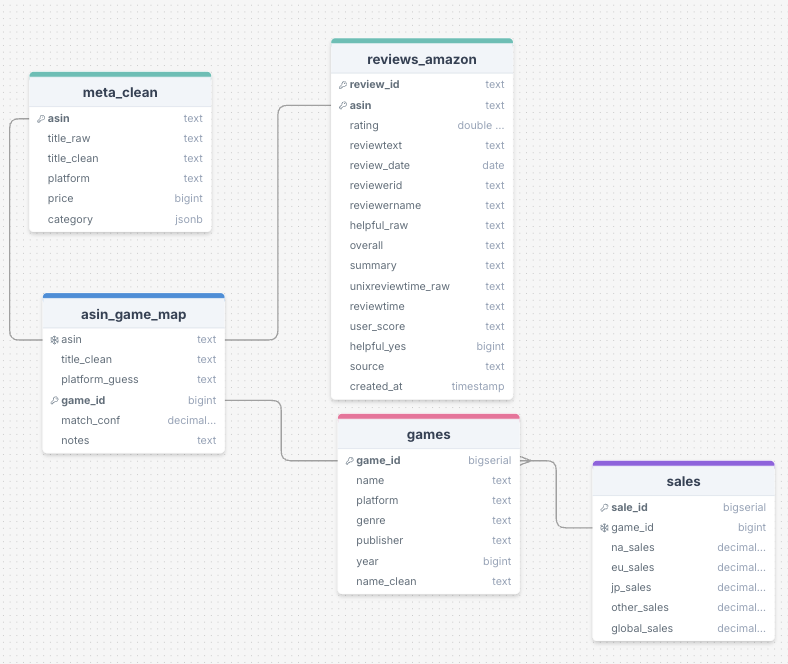